# Case Study - Senegal Covid-19
Using ABC-methods to fit models to covid-19 data from Senegal between 24th Jan 2020 (First confirmed cases) and 31st March 2020.

In [1]:
from scipy import stats
import Models
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import seaborn as sns
import ABC

# silence warnings about dodgy division
np.seterr(divide='ignore', invalid='ignore')

# Size plots
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['figure.dpi'] = 100

## Helper Methods

In [2]:
# print results
def print_results(results,num_stats=None):
    used=[]
    n=len(results)
    for x in results:
        if x not in used:
            used.append(x)
            print("([{}],{:.2f}%)".format(",".join([str(y) for y in x]),100*(results.count(x)/n)))
            
    if (num_stats):
        for i in range(num_stats):
            print("(ss_{},{:.2f}%)".format(i,100*(sum(i in row for row in results)/n)))

In [3]:
def estimate_r0(accepted_params,weights=None,interval_width=.9):
    if (interval_width<=0) or (interval_width>=1): raise ValueError("`interval_width` must be in (0,1)")
    
    weights=weights if (weights) else [1/len(accepted_params) for _ in range(len(accepted_params))]
    
    r0s=[]
    for _ in range(1000):
        ind=np.random.choice(len(accepted_params),size=1,p=weights)
        params=accepted_params[ind[0]]
        r0s.append(params[2]/params[3])
    
    lower_bound=(1-interval_width)/2
    upper_bound=1-lower_bound
    
    return np.quantile(r0s,lower_bound),np.quantile(r0s,upper_bound)

In [4]:
def ci_parameters(accepted_values,alpha=.05,weights=None):
    
    if (weights):
        zipped = zip(accepted_values, weights)
        weighted = []
        for (a, w) in zipped:
            w=int(1000*w)
            for j in range(w):
                weighted.append(a)
    else: weighted=accepted_values
    
    ub=np.percentile(weighted,100*(1-alpha/2),axis=0)
    lb=np.percentile(weighted,100*(alpha/2),axis=0)
    
    return (lb,ub)

In [5]:
def ir_plot(model):
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)

    ax.margins(0)

    xs=model.x_obs
    ys=model.observe()

    # I
    i=1
    y_obs=[y[i] for y in ys]
    ax.scatter(xs,y_obs,c="blue",label="Infectious")

    # R
    i=2
    y_obs=[y[i] for y in ys]
    ax.scatter(xs,y_obs,c="red",label="Removed")

    ax.set_xlabel("Days",fontsize=16)
    ax.set_ylabel("Population Size (00s)",fontsize=16)

    ax.set_xticks(list(range(0,max(xs,key=lambda x:x[0])[0],7))+xs[-1])
    ax.set_yticks(np.linspace(0, ax.get_ylim()[1], 5))
    ax.set_yticklabels(["{:,.0f}".format(x//100) for x in np.linspace(0, ax.get_ylim()[1], 5)])

    plt.legend()
    plt.grid()
    plt.show()

In [6]:
def plot_accepted_ir_observations(ax:plt.Axes,x_obs:int,y_obs:[[float]],accepted_params:[[float]],predicted_model:Models.Model) -> plt.Axes:
    
    accepted_observations=[predicted_model.copy(params).observe() for params in accepted_params]
    
    # plot acceped
    for obs in accepted_observations:
        i_obs=[y[1] for y in obs]
        r_obs=[y[2] for y in obs]
        
        ax.scatter(x_obs,i_obs,c="blue",alpha=.5,marker="x")
        ax.scatter(x_obs,r_obs,c="red",alpha=.5,marker="x")

    # plot observed
    ax.plot(x_obs,[y[1] for y in y_obs],c="blue") # label="Observed I"
    ax.plot(x_obs,[y[2] for y in y_obs],c="red") # label="Observed R"
    
    # plot predicition
    y_pred=predicted_model.observe()
    ax.plot(x_obs,[y[1] for y in y_pred],c="blue",ls="--") # label="Observed I"
    ax.plot(x_obs,[y[2] for y in y_pred],c="red",ls="--") # label="Observed R"

    # make legend
    f = lambda m,l,c: ax.plot([],[], marker=m,color=c,ls=l)[0]
    handles = [f("s","",c) for c in ["blue","red"]]
    handles+=[f("x","","black")]
    handles+= [f(None,l,"black") for l in ["-","--"]]

    ax.legend(handles=handles,labels=["I","R","Accepted","Observed","Predicted"],loc="upper left",ncol=2)
    
    y_min=0
    y_max=4000*(max(max([y[1] for y in y_obs]),max([y[2] for y in y_obs]))//100 +1)
    y_max=min(y_max,ax.get_ylim()[1])
    
    ax.set_ylim(y_min,y_max)
    
    ax.set_xlabel("Day",fontsize=16)
    ax.set_ylabel("Population Size (00s)",fontsize=16)

    ax.set_xticks(list(range(0,max(x_obs,key=lambda x:x[0])[0],5))+x_obs[-1])
    ax.set_yticks(np.linspace(0, ax.get_ylim()[1], 5))
    ax.set_yticklabels(["{:,.0f}".format(x//100) for x in np.linspace(0, ax.get_ylim()[1], 5)])
    
    ax.margins(0)

    return ax


In [7]:
def plot_parameter_posteriors(parameter_names:[str],accepted_parameters:[[float]],predicted_vals:[float],priors:["stats.Distribution"],weights=None) -> plt.Figure:
    fig=plt.Figure()

    weights = weights if (weights) else [1/len(accepted_parameters) for _ in range(len(accepted_parameters))]
    
    acc_params_x=[p[0] for p in accepted_parameters]
    acc_params_y=[p[1] for p in accepted_parameters]
    
    fig = plt.figure()
    gs = GridSpec(4, 4)

    ax_scatter = fig.add_subplot(gs[1:4, 0:3])
    ax_hist_x = fig.add_subplot(gs[0,0:3])
    ax_hist_y = fig.add_subplot(gs[1:4, 3])

    # plot scatter
    sns.kdeplot(acc_params_x,acc_params_y,cmap="Blues", shade=True,weights=weights,ax=ax_scatter)
    
    # plot accepted data
    ax_hist_x.hist(acc_params_x,density=True)
    ax_hist_y.hist(acc_params_y,orientation='horizontal',density=True)

    # plot priors used
    hist_x_xs=np.linspace(min(acc_params_x+[priors[0].ppf(.01)-.25]),max(acc_params_x+[priors[0].ppf(.99)+.25]),100)
    ax_hist_x.plot(hist_x_xs,priors[0].pdf(hist_x_xs),"k-",lw=2, label='Prior')
    hist_y_xs=np.linspace(min(acc_params_y+[priors[1].ppf(.01)-.25]),max(acc_params_y+[priors[1].ppf(.99)+.25]),100)
    ax_hist_y.plot(priors[1].pdf(hist_y_xs),hist_y_xs,"k-",lw=2, label='Prior')
    
    # plot smooth posterior (ie KDE)
    density_x=stats.kde.gaussian_kde(acc_params_x,weights=weights)
    ax_hist_x.plot(hist_x_xs,density_x(hist_x_xs),"--",lw=2,c="orange",label="Posterior KDE")
    density_y=stats.kde.gaussian_kde(acc_params_y,weights=weights)
    ax_hist_y.plot(density_y(hist_y_xs),hist_y_xs,"--",lw=2,c="orange",label="Posterior KDE")
        
    # plot posterior mean
    ax_hist_x.vlines(predicted_vals[0],ymin=0,ymax=ax_hist_x.get_ylim()[1],colors="orange")
    ax_hist_y.hlines(predicted_vals[1],xmin=0,xmax=ax_hist_y.get_xlim()[1],colors="orange")
    
    # make legend
    f = lambda m,l,c: ax_scatter.plot([],[], marker=m,color=c,ls=l)[0]
    handles=[f(None,"-","black"),f(None,"-","orange"),f(None,"--","orange"),f("s","","#1f77b4")]

#     ax_scatter.legend(handles=handles,labels=["Prior","Posterior Mean","Posterior KDE","Accepted"],fontsize=18)
    ax_scatter.set_xlim((hist_x_xs[0],hist_x_xs[-1]))
    ax_scatter.set_ylim((hist_y_xs[0],hist_y_xs[-1]))

    ax_scatter.set_xlabel(parameter_names[0])
    ax_scatter.set_ylabel(parameter_names[1])
    
    ax_scatter.margins(0)
    ax_hist_x.margins(0)
    ax_hist_y.margins(0)
    
    return fig


In [33]:
# plot of model projection with confidence intervals
def plot_ir_model_ci(ax,x_obs,y_obs,predicted_model,accepted_params,weights=None,alpha=0.05,legend=True):
    xs=x_obs
    ys=y_obs
    obs=[]
    
    weights=weights if(weights) else [1/len(accepted_params) for _ in range(len(accepted_params))]
    
    for _ in range(10000):
        ind=np.random.choice(len(accepted_params),size=1,p=weights)[0]
        params=accepted_params[ind]
        temp_model=predicted_model.copy(params)
        new_obs=temp_model.observe()
        obs.append(new_obs)
    
    # Plot true given data
    ax.plot(xs,[y[1] for y in ys],c="blue") # label="Observed I"
    ax.plot(xs,[y[2] for y in ys],c="red",) # label="Observed R"
    
    # Calculate & Plot Predictions
    means=[]
    upper_bounds=[]
    lower_bounds=[]
    
    for i in range(len(y_obs)):
        y_is=[o[i] for o in obs]
        
        mean=np.mean(y_is,axis=0)
        ub=np.percentile(y_is,100*(1-alpha/2),axis=0)
        lb=np.percentile(y_is,100*(alpha/2),axis=0)
        
        means+=[mean]
        upper_bounds+=[ub]
        lower_bounds+=[lb]
    
    # I
    i=1
#     ax.plot(xs,[m[i] for m in means],c="blue",ls="--") # label="Predicted I"
    ax.plot(xs,[y[i] for y in predicted_model.observe()],c="blue",ls="--") # label="Predicted I"
    ax.fill_between([x[0] for x in xs],[l[i] for l in lower_bounds],[u[i] for u in upper_bounds]
                   ,color="blue",alpha=.2)
    
    # R
    i=2
#     ax.plot(xs,[m[i] for m in means],c="red",ls="--") # label="Predicted R"
    ax.plot(xs,[y[i] for y in predicted_model.observe()],c="red",ls="--") # label="Predicted R"
    ax.fill_between([x[0] for x in xs],[l[i] for l in lower_bounds],[u[i] for u in upper_bounds]
                   ,color="red",alpha=.2)
    
    # make legend
    if (legend):
        f = lambda m,l,c: plt.plot([],[], marker=m,color=c,ls=l)[0]
        handles = [f("s","",c) for c in ["blue","red"]]
        handles+= [f(None,l,"black") for l in ["-","--"]]

        ax.legend(handles=handles,labels=["I","R","Observed","Fitted"],loc="upper left",ncol=2)
    
    y_min=0
    y_max=4*(max(max([y[1] for y in ys]),max([y[2] for y in ys])))
    y_max=100*(1+min(y_max,ax.get_ylim()[1])//100)
    
    ax.set_ylim(y_min,y_max)
    
    ax.set_title("{}% CI for Population Sizes.".format(int(100*(1-alpha))),fontsize=20)

    ax.set_xlabel("Day",fontsize=16)
    ax.set_ylabel("Population Size (00s)",fontsize=16)

    ax.set_xticks(list(range(0,max(xs,key=lambda x:x[0])[0],5))+xs[-1])
    ax.set_yticks(np.linspace(0, y_max, 5))

# The Data

In [141]:
true_model=Models.SenegalRonaData()

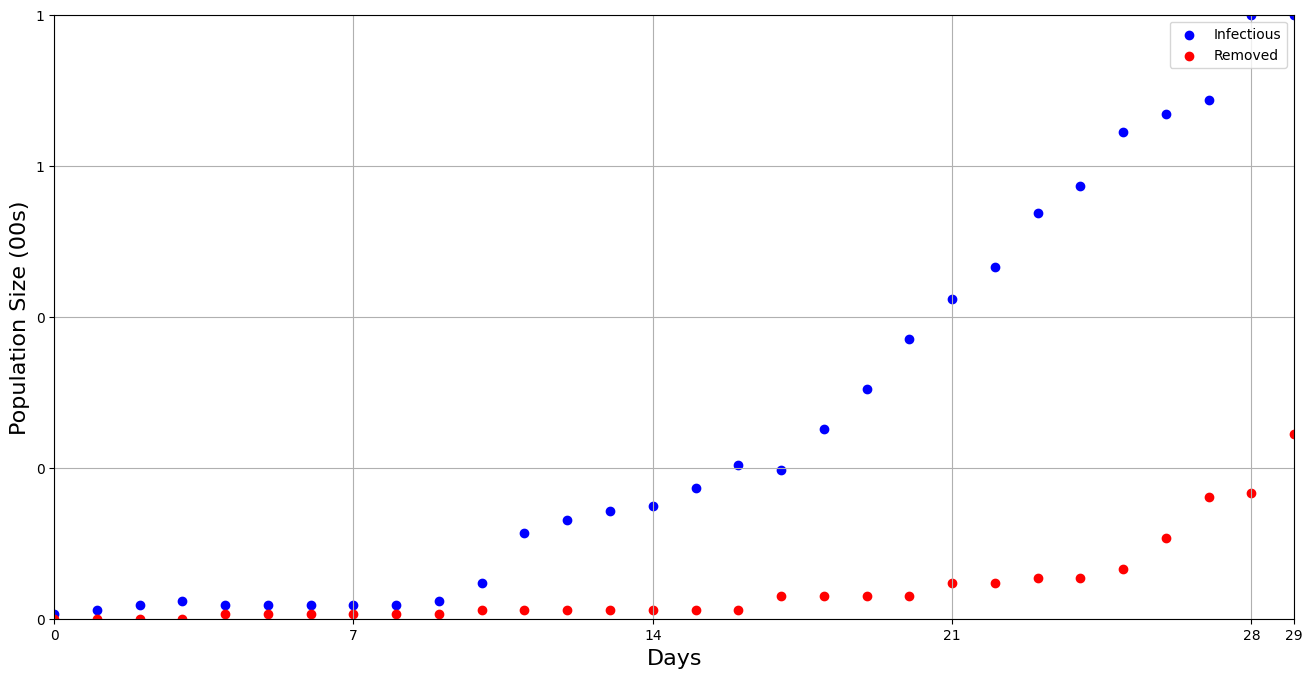

In [142]:
ir_plot(true_model)

# Fitting - Standard SIR Model (Log_L2)

In [107]:
theorised_model=Models.SIRModel(params=[1,1,1,1],n_obs=30,x_obs=[[i] for i in range(30)])
sir_priors=[stats.uniform(16743927,0),stats.uniform(2,0),stats.uniform(0,0.5),stats.uniform(.01,.1)]
sir_smc_priors=[stats.uniform(16743927,1),stats.uniform(2,0.5),stats.uniform(0,0.5),stats.uniform(.01,.1)]

In [108]:
%%time
# ABC-Rejection Sampling (Best Samples)
np.random.seed(16111998) # Fix random seed

sampling_details={"sampling_method":"best","num_runs":500000,"sample_size":500,"distance_measure":ABC.log_l2_norm}
group_dim = lambda ys,i,norm=1: [norm*y[i] for y in ys]
f=lambda ys,i,norm=1:list(np.cumsum([norm*y[i] for y in ys]))
# summary_stats=[lambda ys:group_dim(ys,1),lambda ys:group_dim(ys,2)]
summary_stats=[lambda ys:group_dim(ys,1),lambda ys:group_dim(ys,2,3)]

fitted_model_rej,accepted_params_rej=ABC.abc_rejcection(n_obs=30,y_obs=true_model.observe(),fitting_model=theorised_model,priors=sir_priors,sampling_details=sampling_details,summary_stats=summary_stats,show_plots=False)
print("Fitted Model - {}\n".format(fitted_model_rej))

# 90% CI for R0 value
r0_estimate_rej=estimate_r0(accepted_params_rej)
print("R0 - [{:.3f},{:.3f}]".format(r0_estimate_rej[0],r0_estimate_rej[1]))
print("RSSE: {:,.3f}".format(ABC.two_d_rsse(fitted_model_rej.observe(),true_model.observe(),ln=True)))

# 95% CI
beta_ci=ci_parameters([p[2] for p in accepted_params_rej],alpha=.05,weights=None)
gamma_ci=ci_parameters([p[3] for p in accepted_params_rej],alpha=.05,weights=None)
print("Beta - [{:.3f},{:.3f}]\nGamma - [{:.3f},{:.3f}]".format(beta_ci[0],beta_ci[1],gamma_ci[0],gamma_ci[1]))

Fitted Model - Population Size=16,743,927.0      
Initially Infected=2.0
Beta=0.198
Gamma=0.030
R_0=6.552

R0 - [5.996,7.172]
RSSE: 316.296
Beta - [0.194,0.202]
Gamma - [0.027,0.033]
Wall time: 6min 54s


c:\users\dom\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


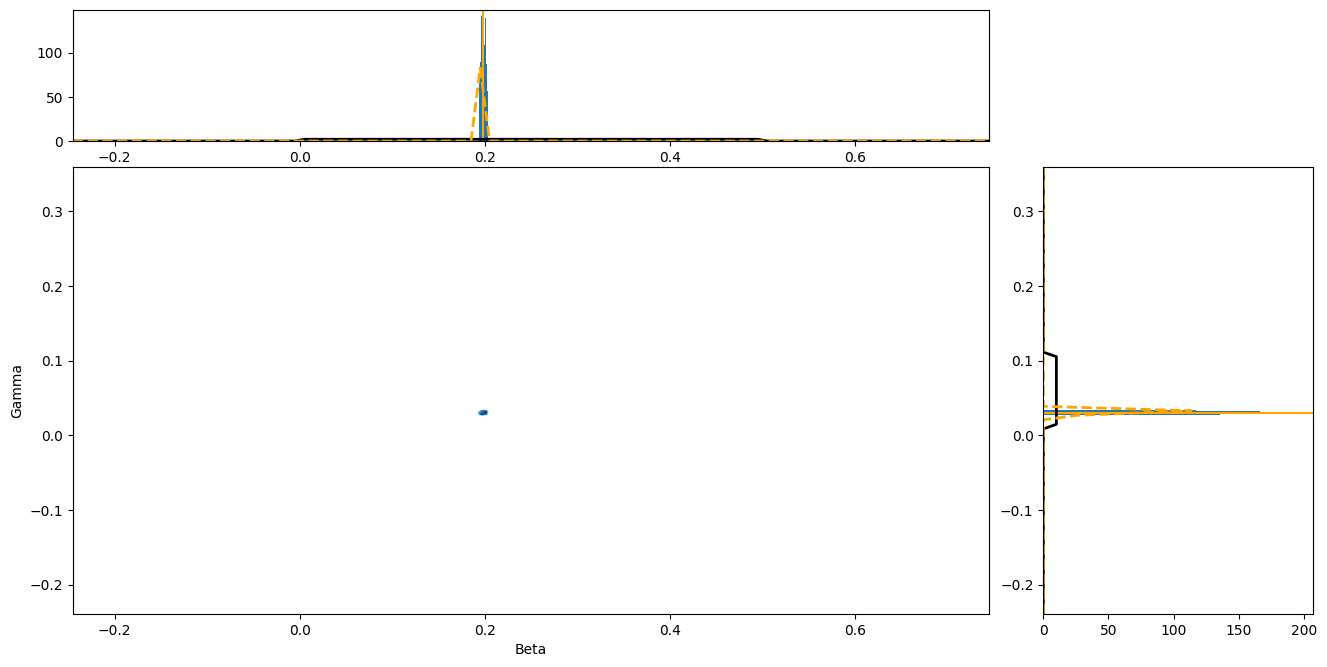

In [109]:
fig=plot_parameter_posteriors(parameter_names=["Beta","Gamma"],accepted_parameters=[p[2:] for p in accepted_params_rej],predicted_vals=fitted_model_rej.params[2:],priors=sir_priors[2:],weights=None)

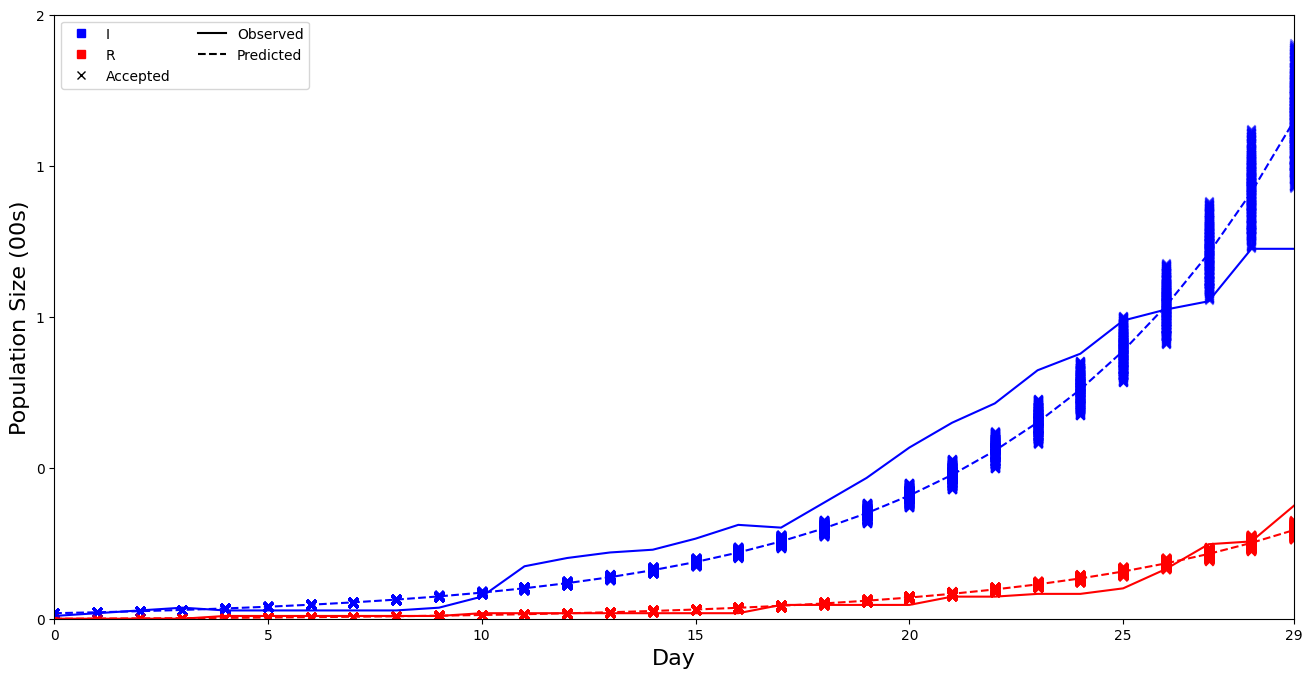

In [143]:
fig=plt.Figure()
ax=fig.add_subplot(1,1,1)

ax=plot_accepted_ir_observations(ax,x_obs=theorised_model.x_obs,y_obs=true_model.observe(),accepted_params=accepted_params_rej,predicted_model=fitted_model_rej)

fig

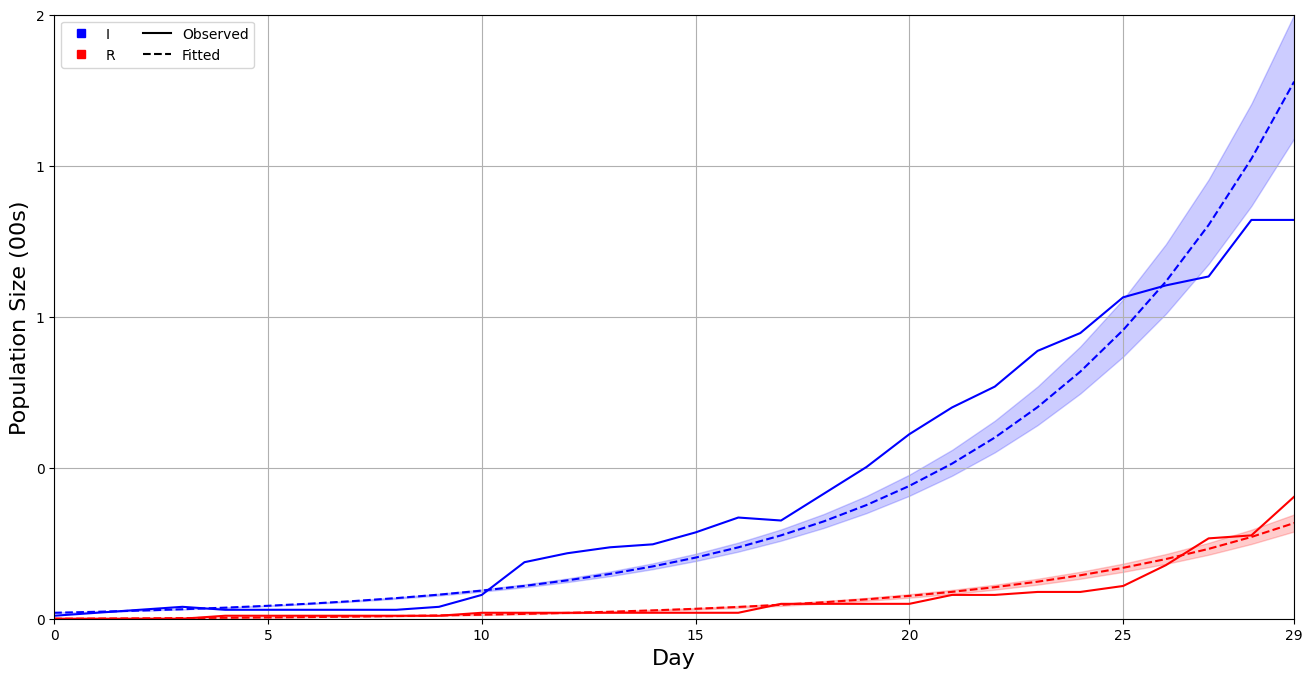

In [144]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.margins(0)

plot_ir_model_ci(ax,true_model.x_obs,true_model.observe(),fitted_model_rej,accepted_params_rej,weights=None,alpha=0.1)
ax.set_title("",fontsize=20)

plt.grid()
plt.show()

# Fitting - Standard SIR Model (L2)

In [89]:
theorised_model=Models.SIRModel(params=[1,1,1,1],n_obs=30,x_obs=[[i] for i in range(30)])
sir_priors=[stats.uniform(16743927,0),stats.uniform(2,0),stats.uniform(0,0.5),stats.uniform(.01,.1)]
sir_smc_priors=[stats.uniform(16743927,1),stats.uniform(2,0.5),stats.uniform(0,0.5),stats.uniform(.01,.1)]

In [90]:
%%time
# ABC-Rejection Sampling (Best Samples)
np.random.seed(16111998) # Fix random seed

sampling_details={"sampling_method":"best","num_runs":500000,"sample_size":100,"distance_measure":ABC.l2_norm}
group_dim = lambda ys,i,norm=1: [norm*y[i] for y in ys]
f=lambda ys,i,norm=1:list(np.cumsum([norm*y[i] for y in ys]))
# summary_stats=[lambda ys:group_dim(ys,1),lambda ys:group_dim(ys,2)]
summary_stats=[lambda ys:group_dim(ys,1),lambda ys:group_dim(ys,2,3)]

fitted_model_rej,accepted_params_rej=ABC.abc_rejcection(n_obs=30,y_obs=true_model.observe(),fitting_model=theorised_model,priors=sir_priors,sampling_details=sampling_details,summary_stats=summary_stats,show_plots=False)
print("Fitted Model - {}\n".format(fitted_model_rej))

# 90% CI for R0 value
r0_estimate_rej=estimate_r0(accepted_params_rej)
print("R0 - [{:.3f},{:.3f}]".format(r0_estimate_rej[0],r0_estimate_rej[1]))
print("RSSE: {:,.3f}".format(ABC.two_d_rsse(fitted_model_rej.observe(),true_model.observe(),ln=True)))

# 95% CI
beta_ci=ci_parameters([p[2] for p in accepted_params_rej],alpha=.05,weights=None)
gamma_ci=ci_parameters([p[3] for p in accepted_params_rej],alpha=.05,weights=None)
print("Beta - [{:.3f},{:.3f}]\nGamma - [{:.3f},{:.3f}]".format(beta_ci[0],beta_ci[1],gamma_ci[0],gamma_ci[1]))

Fitted Model - Population Size=16,743,927.0      
Initially Infected=2.0
Beta=0.197
Gamma=0.032
R_0=6.157

R0 - [5.913,6.503]
RSSE: 333.644
Beta - [0.195,0.199]
Gamma - [0.030,0.034]
Wall time: 4min 53s


c:\users\dom\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


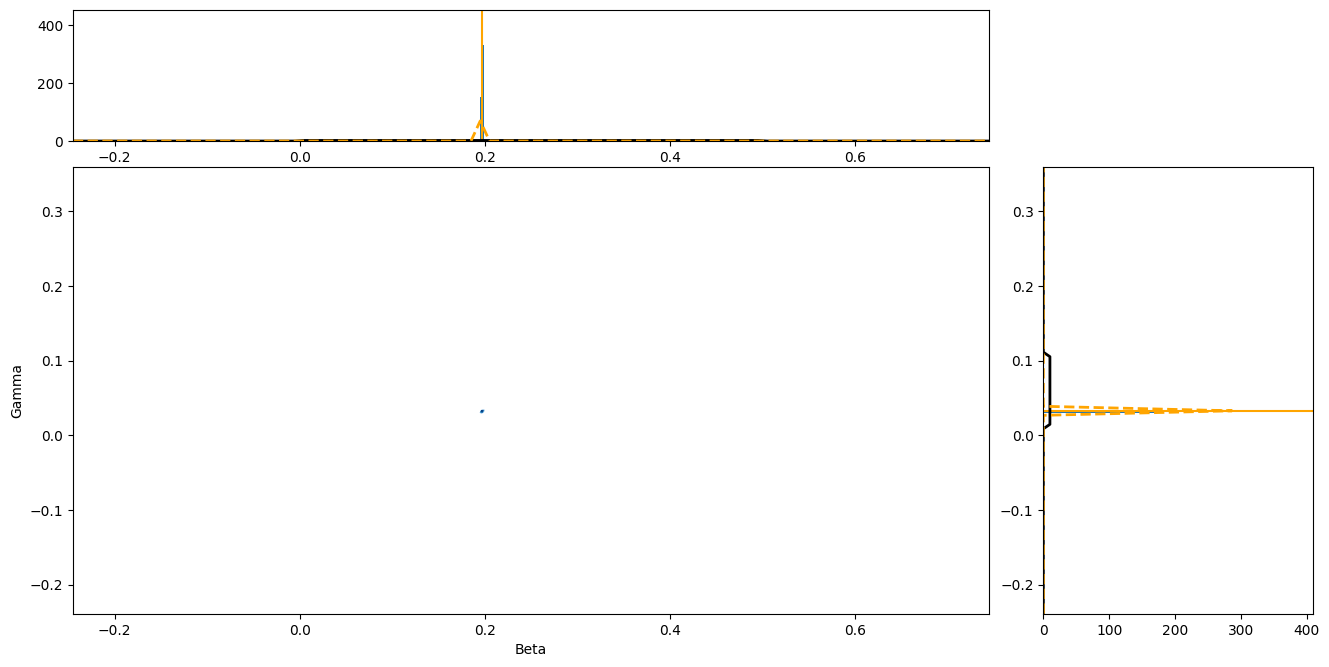

In [91]:
fig=plot_parameter_posteriors(parameter_names=["Beta","Gamma"],accepted_parameters=[p[2:] for p in accepted_params_rej],predicted_vals=fitted_model_rej.params[2:],priors=sir_priors[2:],weights=None)

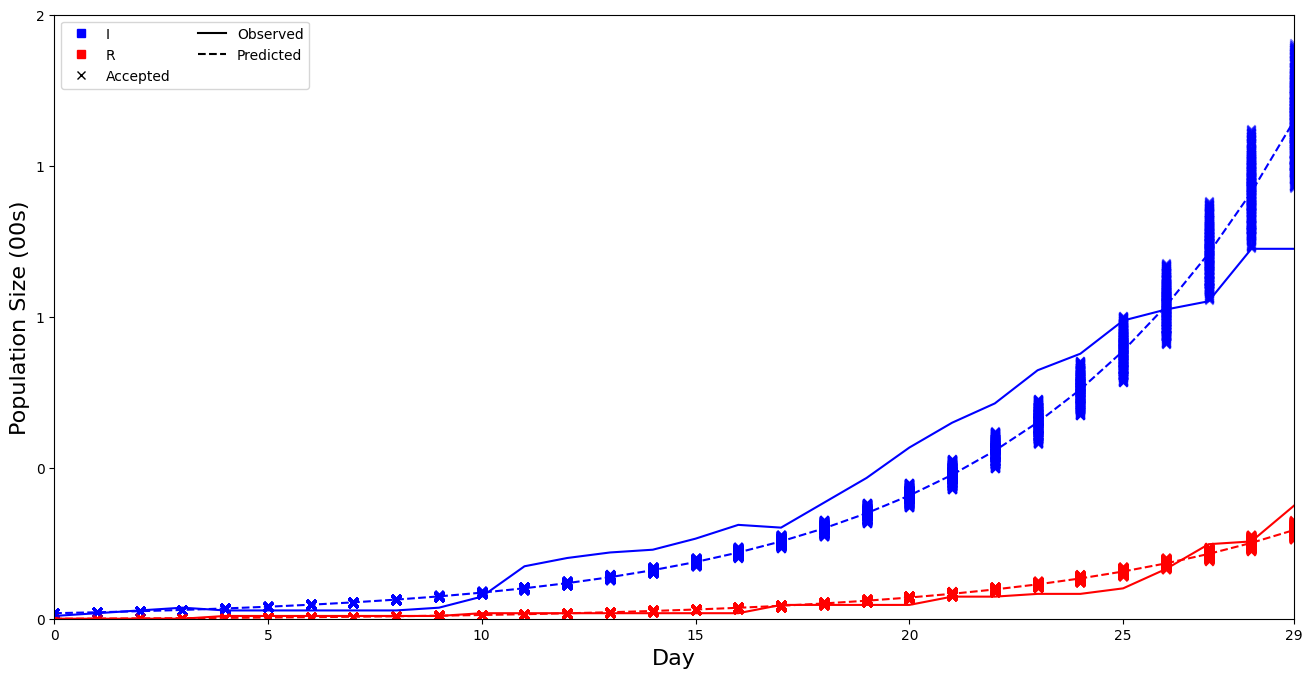

In [145]:
fig=plt.Figure()
ax=fig.add_subplot(1,1,1)

ax=plot_accepted_ir_observations(ax,x_obs=theorised_model.x_obs,y_obs=true_model.observe(),accepted_params=accepted_params_rej,predicted_model=fitted_model_rej)

fig

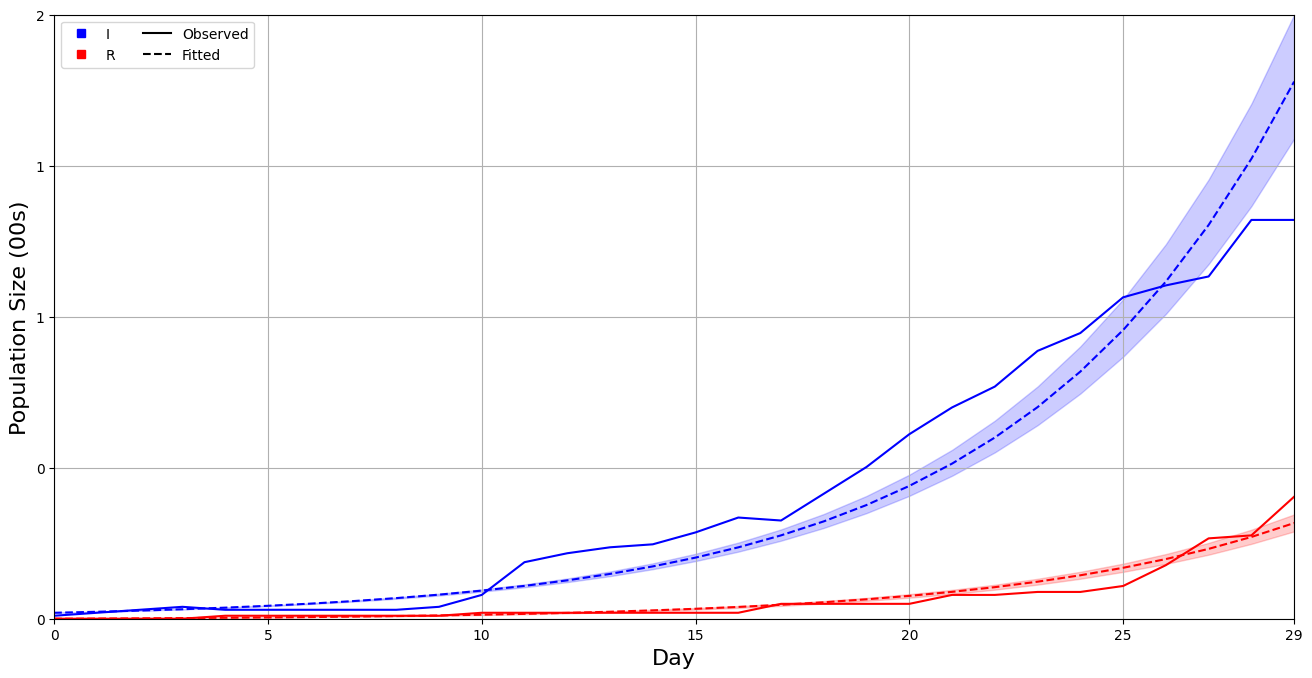

In [146]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.margins(0)

plot_ir_model_ci(ax,true_model.x_obs,true_model.observe(),fitted_model_rej,accepted_params_rej,weights=None,alpha=0.1)
ax.set_title("",fontsize=20)

plt.grid()
plt.show()

# Fit - Adaptive SMC

In [113]:
%%time
# Adaptive ABC-SMC
np.random.seed(16111998) # Fix random seed

group_dim = lambda ys,i,norm=1: [norm*y[i] for y in ys]
f=lambda ys,i,norm=1:list(np.cumsum([norm*y[i] for y in ys]))
# summary_stats=[lambda ys:group_dim(ys,1),lambda ys:group_dim(ys,2)]
summary_stats=[lambda ys:group_dim(ys,1),lambda ys:group_dim(ys,2,3)]

fitted_model_adapt_smc,accepted_params_adapt_smc,weights_adapt_smc=ABC.adaptive_abc_smc(n_obs=30,y_obs=true_model.observe(),fitting_model=theorised_model,priors=sir_smc_priors,
    max_steps=100,sample_size=100,max_simulations=5000,summary_stats=summary_stats,initial_scaling_factor=10000,
    acceptance_kernel=ABC.uniform_kernel,alpha=.9,distance_measure=ABC.log_l2_norm,show_plots=False)

print("Fitted Model - {}\n".format(fitted_semi_model_ir))

# 90% CI for R0 value
r0_estimate_adapt_smc=estimate_r0(accepted_semi_params_ir,weights=weights_adapt_smc)
print("R0 - [{:.3f},{:.3f}]".format(r0_estimate_adapt_smc[0],r0_estimate_adapt_smc[1]))
print("RSSE: {:,.3f}".format(ABC.two_d_rsse(fitted_semi_model_ir.observe(),true_model.observe(),ln=True)))

# 95% CI
beta_ci=ci_parameters([p[2] for p in accepted_semi_params_ir],alpha=.05,weights=weights_adapt_smc)
gamma_ci=ci_parameters([p[3] for p in accepted_semi_params_ir],alpha=.05,weights=weights_adapt_smc)
print("Beta - [{:.3f},{:.3f}]\nGamma - [{:.3f},{:.3f}]".format(beta_ci[0],beta_ci[1],gamma_ci[0],gamma_ci[1]))

(100) - 100/100
Total Sims = 100 < 5,000

Perturbance Variances=[0.06984171 0.02053917 0.01797321 0.00090909]                       
(0/100 - 114) - 99/100 (eps=29.418>0.000)
Total Sims = 214 < 5,000

Perturbance Variances=[0.06662022 0.0201507  0.01182313 0.00084393]                       
(1/100 - 106) - 99/100 (eps=25.492>0.000)
Total Sims = 320 < 5,000

Perturbance Variances=[0.06289341 0.0168701  0.00748795 0.00080669]                       
(2/100 - 114) - 99/100 (eps=21.488>0.000)
Total Sims = 434 < 5,000

Perturbance Variances=[0.06892285 0.01735349 0.00561452 0.00071395]                       
(3/100 - 109) - 99/100 (eps=16.746>0.000)
Total Sims = 543 < 5,000

Perturbance Variances=[0.07992095 0.01364159 0.00449029 0.00061638]                       
(4/100 - 109) - 99/100 (eps=14.602>0.000)
Total Sims = 652 < 5,000

Perturbance Variances=[0.07075559 0.00851228 0.00470497 0.000579  ]                       
(5/100 - 109) - 99/100 (eps=12.898>0.000)
Total Sims = 761 < 5,000

Pert

c:\users\dom\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


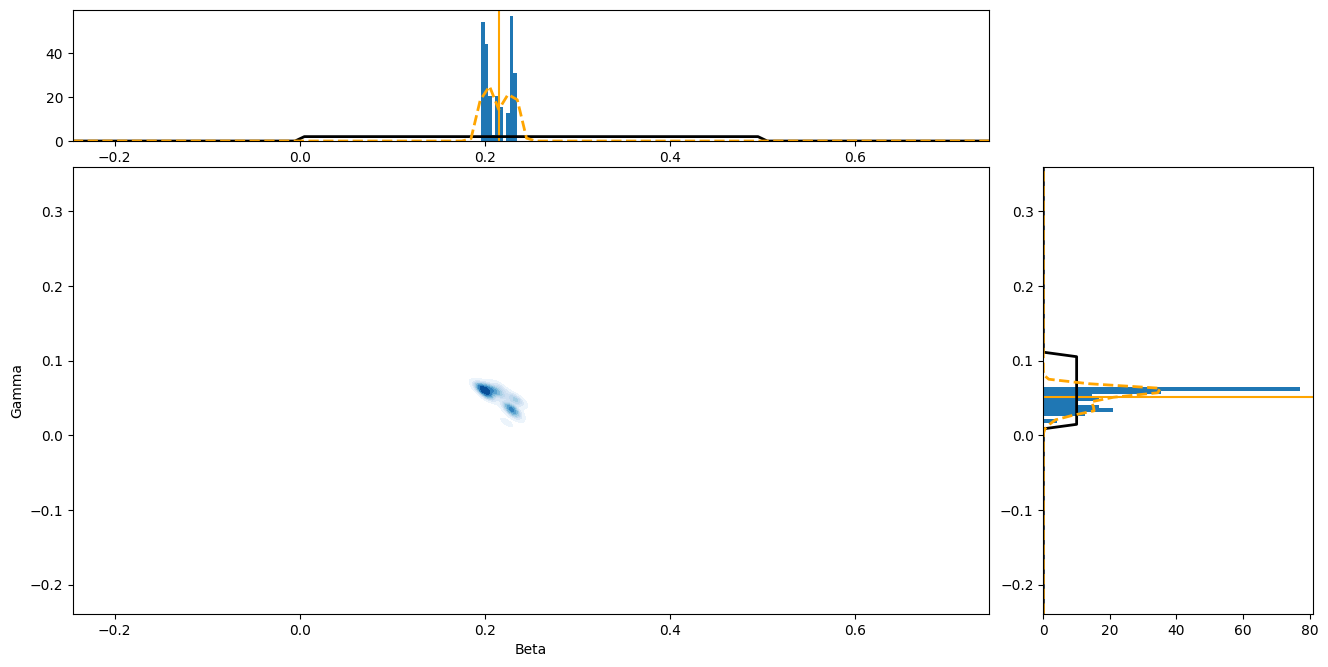

In [114]:
fig=plot_parameter_posteriors(parameter_names=["Beta","Gamma"],accepted_parameters=[p[2:] for p in accepted_params_adapt_smc],predicted_vals=fitted_model_adapt_smc.params[2:],priors=sir_priors[2:],weights=weights_adapt_smc)

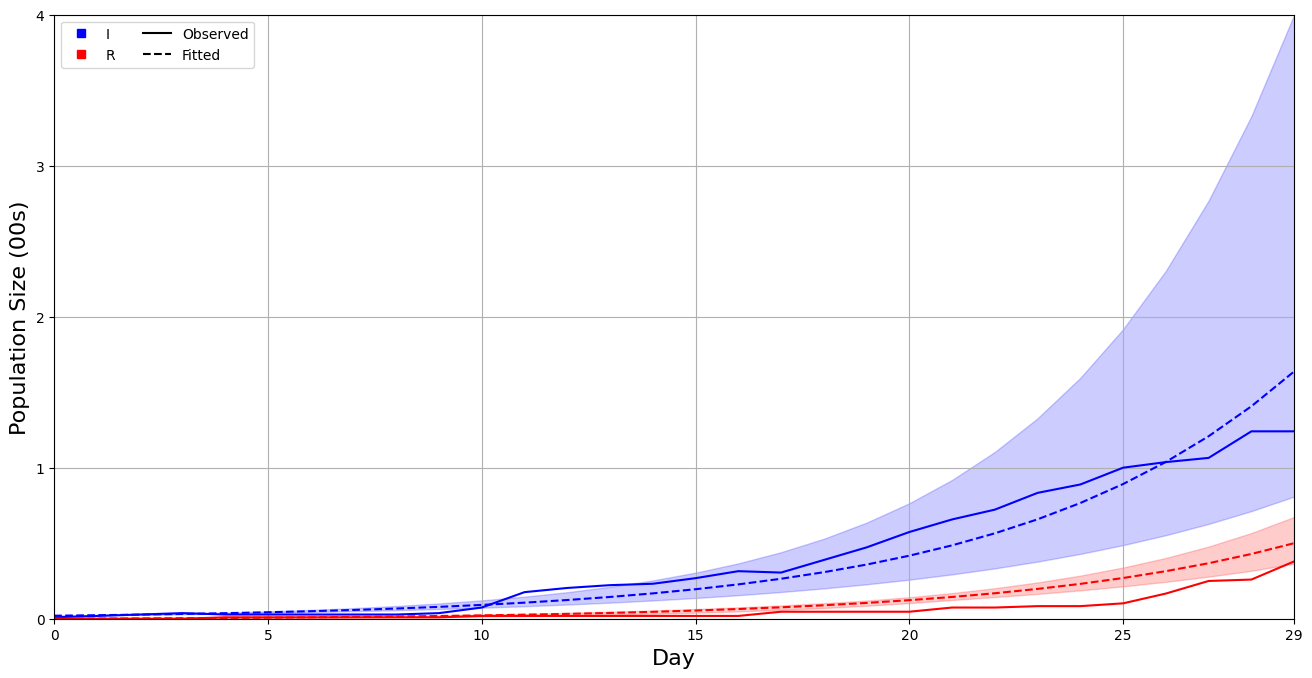

In [147]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.margins(0)

plot_ir_model_ci(ax,true_model.x_obs,true_model.observe(),fitted_model_adapt_smc,accepted_params_adapt_smc,weights=weights_adapt_smc,alpha=0.1)
ax.set_title("",fontsize=20)

plt.grid()
plt.show()

# Fit Semi-Auto Adapative ABC-SMC (IR Model & 5,000 & L2_norm)

In [72]:
true_model=Models.SenegalRonaData_IR()

In [73]:
theorised_model=Models.IRModel(params=[1,1,1,1],n_obs=30,x_obs=[[i] for i in range(30)])
sir_priors=[stats.uniform(16743927,0),stats.uniform(2,0),stats.uniform(0,0.5),stats.uniform(.01,.1)]
sir_smc_priors=[stats.uniform(16743927,1),stats.uniform(2,0.5),stats.uniform(0,0.5),stats.uniform(.01,.1)]

In [79]:
%%time
# ABC-SMC
np.random.seed(16111998) # Fix random seed

summary_stats,_=ABC.abc_semi_auto(n_obs=30,y_obs=true_model.observe(),fitting_model=theorised_model,
                                  priors=sir_smc_priors,distance_measure=ABC.l2_norm,n_pilot_samples=500000,n_pilot_acc=50,n_params_sample_size=5000,printing=True)
print(summary_stats[0](true_model.observe()))

fitted_semi_model_ir,accepted_semi_params_ir,weights_semi_ir=ABC.adaptive_abc_smc(n_obs=30,y_obs=true_model.observe(),fitting_model=theorised_model,priors=sir_smc_priors,
    max_steps=100,sample_size=100,max_simulations=5000,summary_stats=summary_stats,
    acceptance_kernel=ABC.uniform_kernel,alpha=.9,distance_measure=ABC.l2_norm,show_plots=False)

print("Fitted Model - {}\n".format(fitted_semi_model_ir))

# 90% CI for R0 value
r0_estimate_adapt_smc=estimate_r0(accepted_semi_params_ir,weights=weights_semi_ir)
print("R0 - [{:.3f},{:.3f}]".format(r0_estimate_adapt_smc[0],r0_estimate_adapt_smc[1]))
print("RSSE: {:,.3f}".format(ABC.two_d_rsse(fitted_semi_model_ir.observe(),true_model.observe(),ln=True)))

# 95% CI
beta_ci=ci_parameters([p[2] for p in accepted_semi_params_ir],alpha=.05,weights=weights_semi_ir)
gamma_ci=ci_parameters([p[3] for p in accepted_semi_params_ir],alpha=.05,weights=weights_semi_ir)
print("Beta - [{:.3f},{:.3f}]\nGamma - [{:.3f},{:.3f}]".format(beta_ci[0],beta_ci[1],gamma_ci[0],gamma_ci[1]))

Calculated posteriors from pilot.                
Generated 5000 parameter sets.
Generated summary statistics
[-116556054687689.22, 3227674806064.7256, -17545258988.17856, -15662755891.631031]
(100) - 100/100
Total Sims = 100 < 5,000

Perturbance Variances=[0.08433743 0.02094379 0.02025981 0.00092927]                       
(0/100 - 111) - 99/100 (eps=51,457,399,651,348,008.000>0.000)
Total Sims = 211 < 5,000

Perturbance Variances=[0.07814093 0.02244316 0.01789884 0.0008652 ]                       
(1/100 - 112) - 99/100 (eps=12,190,927,971,475,014.000>0.000)
Total Sims = 323 < 5,000

Perturbance Variances=[0.07832823 0.01986937 0.01419675 0.00081822]                       
(2/100 - 110) - 99/100 (eps=7,655,926,708,820,421.000>0.000)
Total Sims = 433 < 5,000

Perturbance Variances=[0.0784482  0.02112555 0.01326566 0.00079556]                       
(3/100 - 112) - 99/100 (eps=3,545,683,486,211,274.000>0.000)
Total Sims = 545 < 5,000

Perturbance Variances=[0.07703747 0.02357088 0.0116

c:\users\dom\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


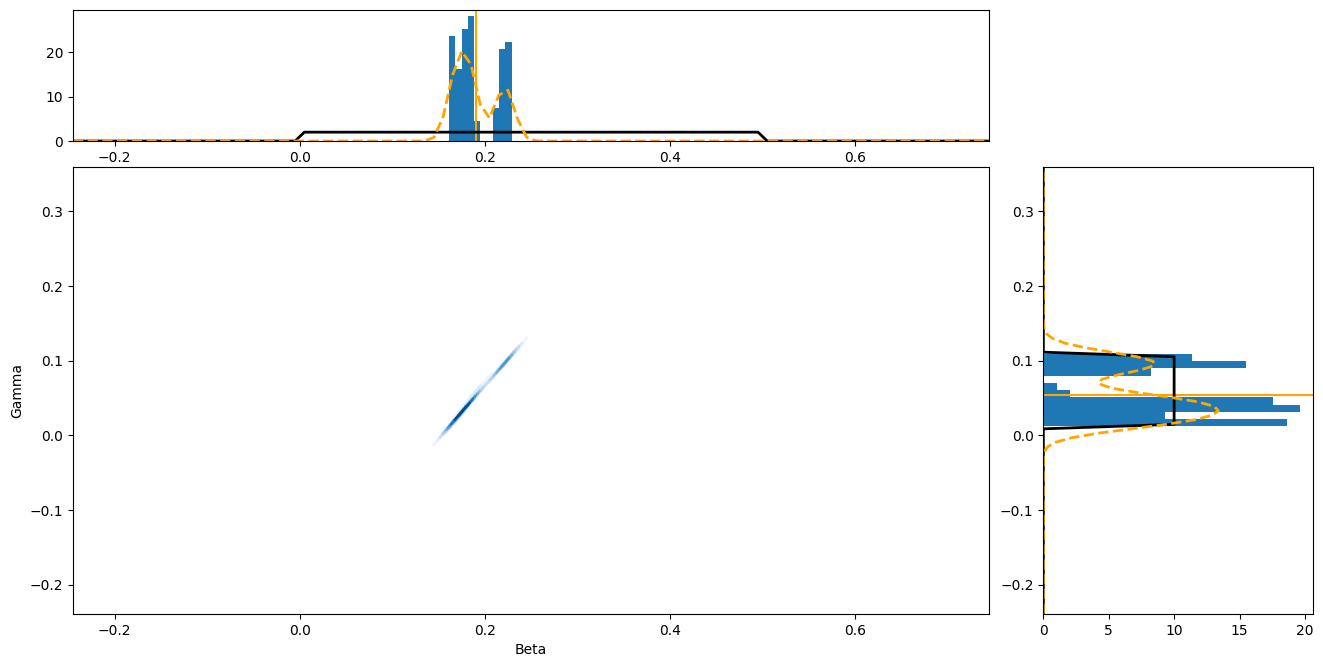

In [81]:
fig=plot_parameter_posteriors(
    parameter_names=["Beta","Gamma"],
    accepted_parameters=[p[2:] for p in accepted_semi_params_ir],
    predicted_vals=fitted_semi_model_ir.params[2:],
    priors=sir_priors[2:],
    weights=weights_semi_ir)

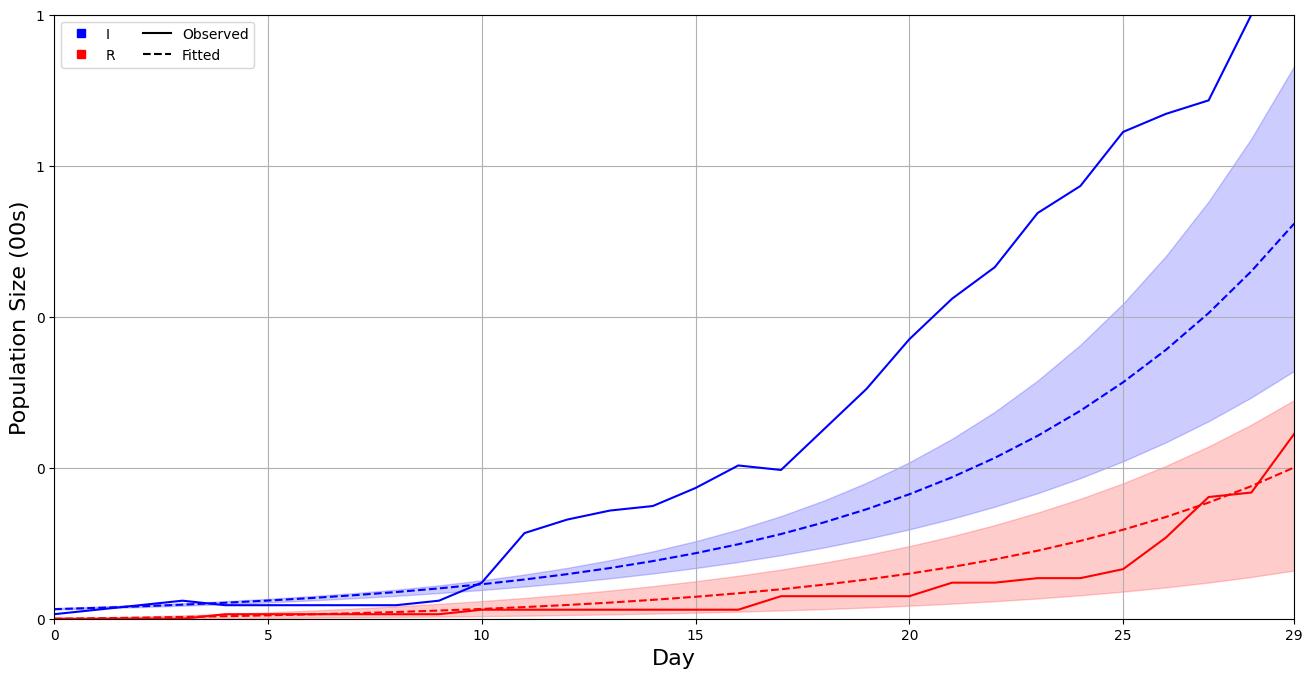

In [148]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.margins(0)

# temp_sir_fitted=Models.SIRModel(fitted_semi_model_ir.params[:2]+[0.18,0.04],30,x_obs=[[i] for i in range(30)])
temp_sir_fitted=Models.SIRModel(fitted_semi_model_ir.params,30,x_obs=[[i] for i in range(30)])

plot_ir_model_ci(ax,temp_sir_fitted.x_obs,Models.SenegalRonaData().observe(),temp_sir_fitted,accepted_semi_params_ir,weights=weights_semi_ir,alpha=0.05)
ax.set_title("",fontsize=20)

plt.grid()
plt.show()

# Fit Semi-Auto Adapative ABC-SMC (IR Model & 10,000 & L2_norm)

In [154]:
true_model=Models.SenegalRonaData_IR()

In [155]:
theorised_model=Models.IRModel(params=[1,1,1,1],n_obs=30,x_obs=[[i] for i in range(30)])
sir_priors=[stats.uniform(16743927,0),stats.uniform(2,0),stats.uniform(0,0.5),stats.uniform(.01,.1)]
sir_smc_priors=[stats.uniform(16743927,1),stats.uniform(2,0.5),stats.uniform(0,0.5),stats.uniform(.01,.1)]

In [156]:
%%time
# ABC-SMC
np.random.seed(16111998) # Fix random seed

summary_stats,_=ABC.abc_semi_auto(n_obs=30,y_obs=true_model.observe(),fitting_model=theorised_model,
                                  priors=sir_smc_priors,distance_measure=ABC.log_l2_norm,n_pilot_samples=500000,n_pilot_acc=50,n_params_sample_size=5000,printing=True)
print(summary_stats[0](true_model.observe()))

fitted_semi_model_ir_2,accepted_semi_params_ir_2,weights_semi_ir_2=ABC.adaptive_abc_smc(n_obs=30,y_obs=true_model.observe(),fitting_model=theorised_model,priors=sir_smc_priors,
    max_steps=100,sample_size=100,max_simulations=10000,summary_stats=summary_stats,
    acceptance_kernel=ABC.uniform_kernel,alpha=.9,distance_measure=ABC.l2_norm,show_plots=False)

print("Fitted Model - {}\n".format(fitted_semi_model_ir))

Calculated posteriors from pilot.                
Generated 5000 parameter sets.
Generated summary statistics
[33895557535418.062, 193388143455576.2, -2833762817922.95, -3955186080377.7476]
(100) - 100/100
Total Sims = 100 < 10,000

Perturbance Variances=[0.08433743 0.02094379 0.02025981 0.00092927]                       
(0/100 - 112) - 99/100 (eps=49,106,436,019,540,304.000>0.000)
Total Sims = 212 < 10,000

Perturbance Variances=[0.07922412 0.0223264  0.01801515 0.000868  ]                       
(1/100 - 111) - 99/100 (eps=11,203,374,353,222,092.000>0.000)
Total Sims = 323 < 10,000

Perturbance Variances=[0.08512024 0.02374227 0.01818571 0.00085263]                       
(2/100 - 113) - 99/100 (eps=8,684,670,975,475,120.000>0.000)
Total Sims = 436 < 10,000

Perturbance Variances=[0.0836055  0.02798395 0.01470964 0.00082404]                       
(3/100 - 114) - 99/100 (eps=4,905,141,953,797,779.000>0.000)
Total Sims = 550 < 10,000

Perturbance Variances=[0.06071765 0.02931715 0.01

(44/100 - 209) - 99/100 (eps=12,029,621,561,053.213>0.000)
Total Sims = 5,638 < 10,000

Perturbance Variances=[0.05637881 0.01943908 0.00082684 0.00062318]                       
(45/100 - 151) - 99/100 (eps=10,420,157,330,837.777>0.000)
Total Sims = 5,789 < 10,000

Perturbance Variances=[0.06112441 0.02453637 0.00098901 0.00076298]                       
(46/100 - 183) - 99/100 (eps=9,247,188,450,919.271>0.000)
Total Sims = 5,972 < 10,000

Perturbance Variances=[0.05716823 0.03520454 0.00134953 0.00105009]                       
(47/100 - 274) - 99/100 (eps=8,546,350,225,724.664>0.000)
Total Sims = 6,246 < 10,000

Perturbance Variances=[0.057491   0.03317    0.00134915 0.00104403]                       
(48/100 - 263) - 99/100 (eps=7,855,830,782,429.021>0.000)
Total Sims = 6,509 < 10,000

Perturbance Variances=[0.0604836  0.03335441 0.00106071 0.00083725]                       
(49/100 - 284) - 99/100 (eps=7,144,646,062,099.248>0.000)
Total Sims = 6,793 < 10,000

Perturbance Variances

NameError: name 'true_model_2' is not defined

In [159]:
# 90% CI for R0 value
r0_estimate_adapt_smc=estimate_r0(accepted_semi_params_ir_2,weights=weights_semi_ir_2)
print("R0 - [{:.3f},{:.3f}]".format(r0_estimate_adapt_smc[0],r0_estimate_adapt_smc[1]))
print("RSSE: {:,.3f}".format(ABC.two_d_rsse(fitted_semi_model_ir_2.observe(),true_model.observe(),ln=True)))

# 95% CI
beta_ci=ci_parameters([p[2] for p in accepted_semi_params_ir_2],alpha=.05,weights=weights_semi_ir_2)
gamma_ci=ci_parameters([p[3] for p in accepted_semi_params_ir_2],alpha=.05,weights=weights_semi_ir_2)
print("Beta - [{:.3f},{:.3f}]\nGamma - [{:.3f},{:.3f}]".format(beta_ci[0],beta_ci[1],gamma_ci[0],gamma_ci[1]))

R0 - [2.547,11.937]
RSSE: 240.813
Beta - [0.163,0.270]
Gamma - [0.013,0.107]


c:\users\dom\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


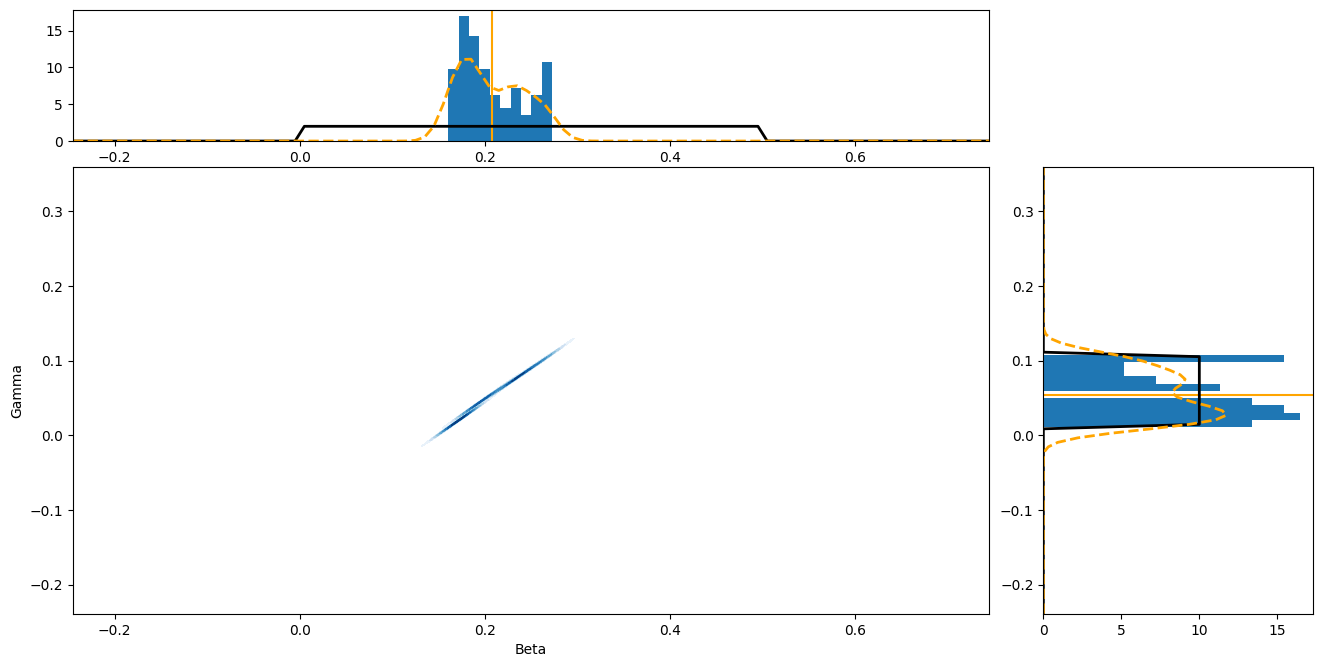

In [157]:
fig=plot_parameter_posteriors(
    parameter_names=["Beta","Gamma"],
    accepted_parameters=[p[2:] for p in accepted_semi_params_ir_2],
    predicted_vals=fitted_semi_model_ir_2.params[2:],
    priors=sir_priors[2:],
    weights=weights_semi_ir_2)

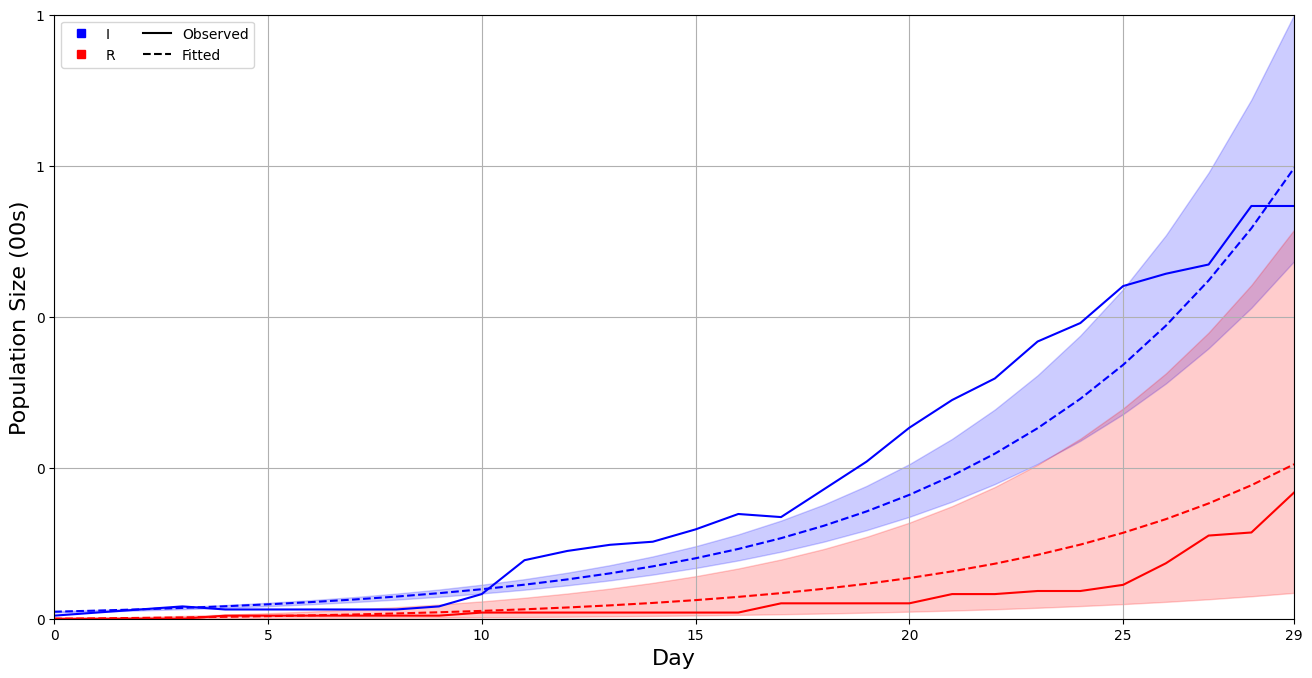

In [158]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.margins(0)

# temp_sir_fitted=Models.SIRModel(fitted_semi_model_ir.params[:2]+[0.18,0.04],30,x_obs=[[i] for i in range(30)])
temp_sir_fitted=Models.SIRModel(fitted_semi_model_ir_2.params,30,x_obs=[[i] for i in range(30)])

plot_ir_model_ci(ax,temp_sir_fitted.x_obs,Models.SenegalRonaData().observe(),temp_sir_fitted,accepted_semi_params_ir_2,weights=weights_semi_ir_2,alpha=0.05)
ax.set_title("",fontsize=20)

plt.grid()
plt.show()

# Minimum Entropy

In [9]:
true_model=Models.SenegalRonaData()

In [10]:
theorised_model=Models.SIRModel(params=[1,1,1,1],n_obs=30,x_obs=[[i] for i in range(30)])
sir_priors=[stats.uniform(16743927,0),stats.uniform(2,0),stats.uniform(0,0.5),stats.uniform(.01,.1)]
sir_smc_priors=[stats.uniform(16743927,1),stats.uniform(2,0.5),stats.uniform(0,0.5),stats.uniform(.01,.1)]

In [11]:
# # SUMMARY STATISTICS
# scaled to be similiar to peak_infections_date
final_infectious_ss=(lambda ys:[np.log(ys[-1][1])])
final_removed_ss=(lambda ys:[np.log(ys[-1][2])])

net_weekly_infections_ss=(lambda ys:[np.log(abs(ys[i][1]-ys[i-7][1])) for i in range(7,len(ys)-1,7)]) # weekly change in infections (dim=3)
net_weekly_removed_ss=(lambda ys:[np.log(abs(ys[i][2]-ys[i-7][2])) for i in range(7,len(ys)-1,7)])

net_daily_infections_ss=(lambda ys:[np.log(max(abs(ys[i+1][1]-ys[i][1]),1)) for i in range(0,len(ys)-1)]) # daily change in infections (dim=29)
net_daily_removed_ss=(lambda ys:[np.log(max(abs(ys[i+1][2]-ys[i][2]),np.e)) for i in range(0,len(ys)-1)])

mean_infectious_ss=(lambda ys:[5*np.log(np.mean([y[1] for y in ys]))])
mean_removed_ss=(lambda ys:[9*np.log(np.mean([y[2] for y in ys]))])

cum_sum_infectious_ss=(lambda ys:np.cumsum([y[1] for y in ys]))
cum_sum_removed_ss=(lambda ys:np.cumsum([y[1] for y in ys]))

summary_stats=[final_infectious_ss,final_removed_ss, #0,1
               net_weekly_infections_ss,net_weekly_removed_ss, #2,3
               net_daily_infections_ss,net_daily_removed_ss, #4,5
               mean_infectious_ss,mean_removed_ss, #6,7
               cum_sum_infectious_ss,cum_sum_removed_ss] #8,9

In [42]:
%%time
returned_stats=[(4, 6, 7), (3,), (1, 5, 6), (0, 2, 3), (0, 2, 3), (1, 2), (3, 4), (0, 6, 7), (1, 2), (3, 6),(1, 2)]
n_tests=10

for i in range(n_tests):
    print("{}/{} ".format(i,n_tests),end="")
    print(returned_stats,end="\n")
    best_stats,_=ABC.minimum_entropy(summary_stats,n_obs=30,y_obs=true_model.observe(),fitting_model=theorised_model,priors=sir_priors,n_samples=10000,n_accept=100,
                                     min_subset_size=1,max_subset_size=3,printing=False)
    returned_stats.append(best_stats)

print("\n\nResults")
print_results(returned_stats,10)



Results
([4,6,7],9.09%)
([3],9.09%)
([1,5,6],9.09%)
([0,2,3],18.18%)
([1,2],27.27%)
([3,4],9.09%)
([0,6,7],9.09%)
([3,6],9.09%)
(ss_0,27.27%)
(ss_1,36.36%)
(ss_2,45.45%)
(ss_3,45.45%)
(ss_4,18.18%)
(ss_5,9.09%)
(ss_6,36.36%)
(ss_7,18.18%)
(ss_8,0.00%)
(ss_9,0.00%)
Wall time: 762 µs


In [43]:
best_me_ss=[1,2]
me_ss=[summary_stats[i] for i in best_me_ss]

In [44]:
%%time
# ABC-Rejection Sampling (Best Samples)
np.random.seed(16111998) # Fix random seed

sampling_details={"sampling_method":"best","num_runs":500000,"sample_size":500,"distance_measure":ABC.l2_norm}

fitted_model_me,accepted_params_me=ABC.abc_rejcection(n_obs=30,y_obs=true_model.observe(),fitting_model=theorised_model,priors=sir_priors,sampling_details=sampling_details,summary_stats=me_ss,show_plots=False)
print("Fitted Model - {}\n".format(fitted_model_me))

# 90% CI for R0 value
r0_estimate_rej=estimate_r0(accepted_params_me)
print("R0 - [{:.3f},{:.3f}]".format(r0_estimate_rej[0],r0_estimate_rej[1]))
print("RSSE: {:,.3f}".format(ABC.two_d_rsse(fitted_model_me.observe(),true_model.observe(),ln=True)))

# 95% CI
beta_ci=ci_parameters([p[2] for p in accepted_params_me],alpha=.05,weights=None)
gamma_ci=ci_parameters([p[3] for p in accepted_params_me],alpha=.05,weights=None)
print("Beta - [{:.3f},{:.3f}]\nGamma - [{:.3f},{:.3f}]".format(beta_ci[0],beta_ci[1],gamma_ci[0],gamma_ci[1]))

Fitted Model - Population Size=16,743,927.0      
Initially Infected=2.0
Beta=0.206
Gamma=0.041
R_0=5.014

R0 - [4.436,5.818]
RSSE: 323.427
Beta - [0.204,0.208]
Gamma - [0.035,0.046]
Wall time: 4min 59s


c:\users\dom\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


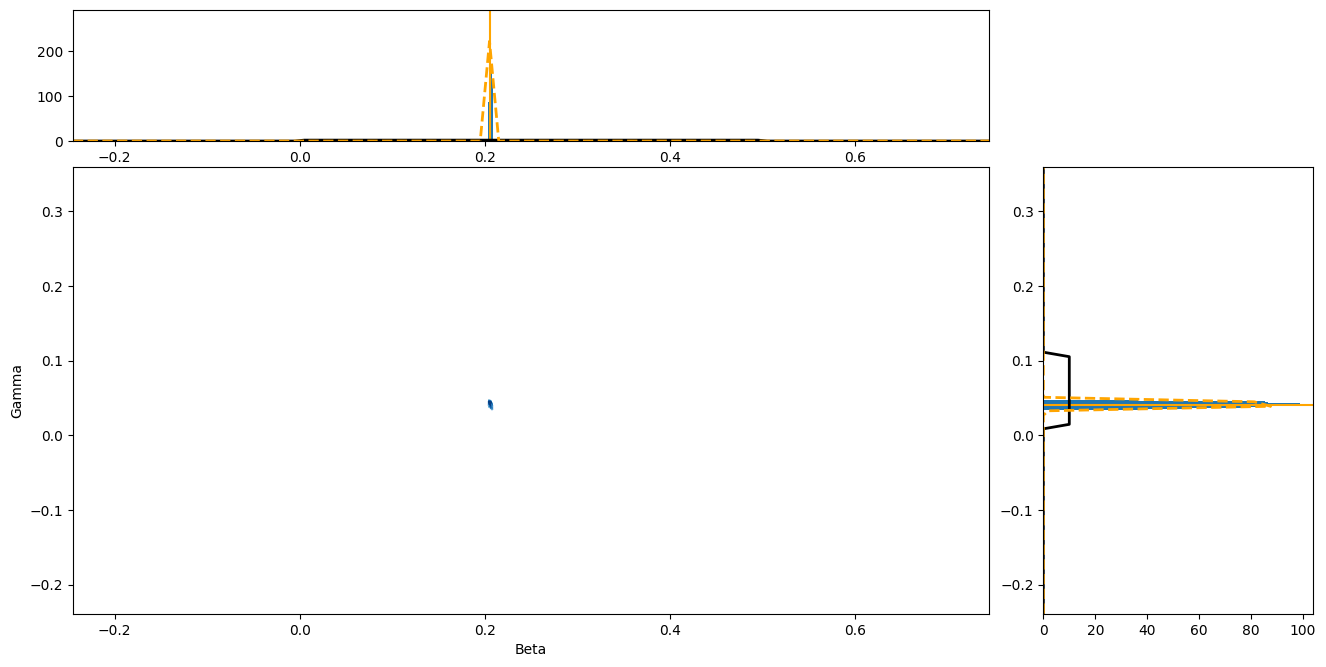

In [45]:
fig=plot_parameter_posteriors(parameter_names=["Beta","Gamma"],accepted_parameters=[p[2:] for p in accepted_params_me],predicted_vals=fitted_model_me.params[2:],priors=sir_priors[2:],weights=None)

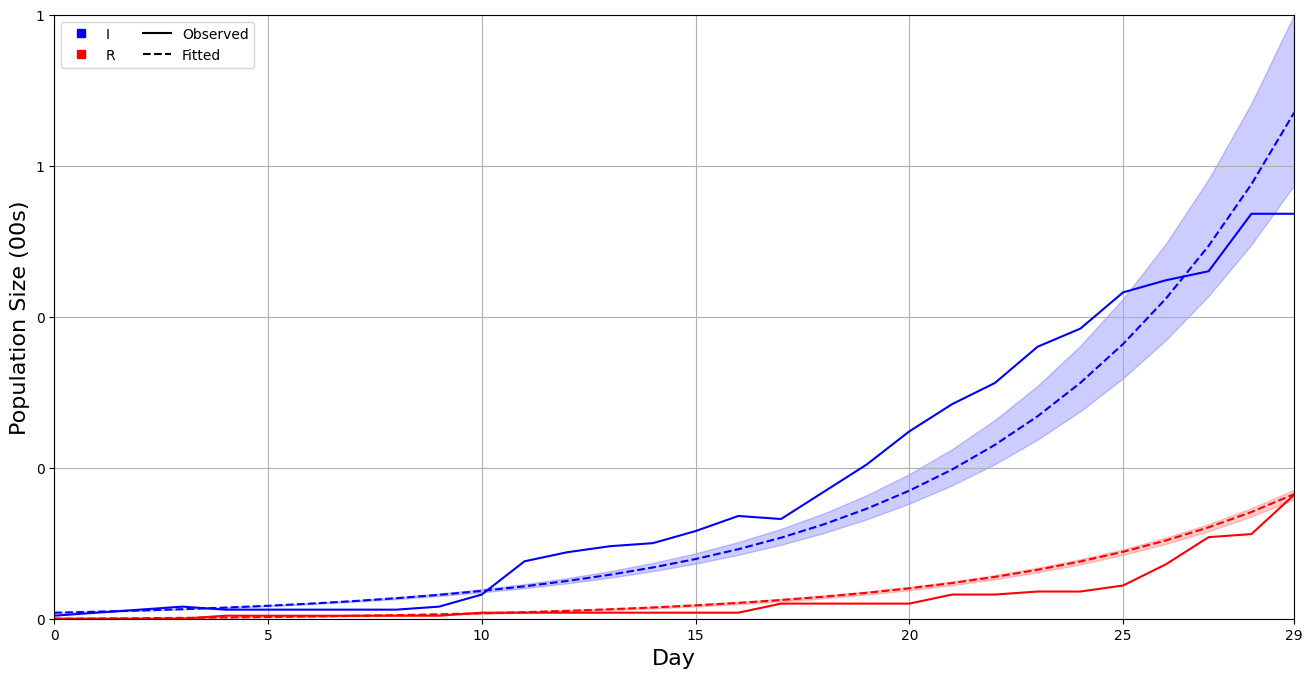

In [46]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.margins(0)

plot_ir_model_ci(ax,true_model.x_obs,true_model.observe(),fitted_model_me,accepted_params_me,weights=None,alpha=0.1)
ax.set_title("",fontsize=20)

plt.grid()
plt.show()

In [47]:
%%time
# Adaptive ABC-SMC
np.random.seed(16111998) # Fix random seed

fitted_model_adapt_me,accepted_params_adapt_me,weights_adapt_me=ABC.adaptive_abc_smc(n_obs=30,y_obs=true_model.observe(),fitting_model=theorised_model,priors=sir_smc_priors,
    max_steps=100,sample_size=100,max_simulations=5000,summary_stats=me_ss,initial_scaling_factor=30,
    acceptance_kernel=ABC.uniform_kernel,alpha=.9,distance_measure=ABC.l2_norm,show_plots=False)

print("Fitted Model - {}\n".format(fitted_model_adapt_me))

# 90% CI for R0 value
r0_estimate_adapt_smc=estimate_r0(accepted_params_adapt_me,weights=weights_adapt_me)
print("R0 - [{:.3f},{:.3f}]".format(r0_estimate_adapt_smc[0],r0_estimate_adapt_smc[1]))
print("RSSE: {:,.3f}".format(ABC.two_d_rsse(fitted_model_adapt_me.observe(),true_model.observe(),ln=True)))

# 95% CI
beta_ci=ci_parameters([p[2] for p in accepted_params_adapt_me],alpha=.05,weights=weights_adapt_me)
gamma_ci=ci_parameters([p[3] for p in accepted_params_adapt_me],alpha=.05,weights=weights_adapt_me)
print("Beta - [{:.3f},{:.3f}]\nGamma - [{:.3f},{:.3f}]".format(beta_ci[0],beta_ci[1],gamma_ci[0],gamma_ci[1]))

(100) - 100/100
Total Sims = 100 < 5,000

Perturbance Variances=[0.06984171 0.02053917 0.01797321 0.00090909]                       
(0/100 - 117) - 99/100 (eps=12.300>0.000)
Total Sims = 217 < 5,000

Perturbance Variances=[0.06623529 0.01877042 0.01169697 0.00084405]                       
(1/100 - 112) - 99/100 (eps=11.039>0.000)
Total Sims = 329 < 5,000

Perturbance Variances=[0.06469358 0.01865612 0.00841873 0.00072278]                       
(2/100 - 116) - 99/100 (eps=10.275>0.000)
Total Sims = 445 < 5,000

Perturbance Variances=[0.06420164 0.0175254  0.00722236 0.0006641 ]                       
(3/100 - 114) - 99/100 (eps=8.260>0.000)
Total Sims = 559 < 5,000

Perturbance Variances=[0.05114703 0.01604527 0.00518156 0.00053919]                       
(4/100 - 109) - 99/100 (eps=7.183>0.000)
Total Sims = 668 < 5,000

Perturbance Variances=[0.04780279 0.0151331  0.00414791 0.00057094]                       
(5/100 - 109) - 99/100 (eps=6.339>0.000)
Total Sims = 777 < 5,000

Perturb

TypeError: 'numpy.float64' object cannot be interpreted as an integer

c:\users\dom\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


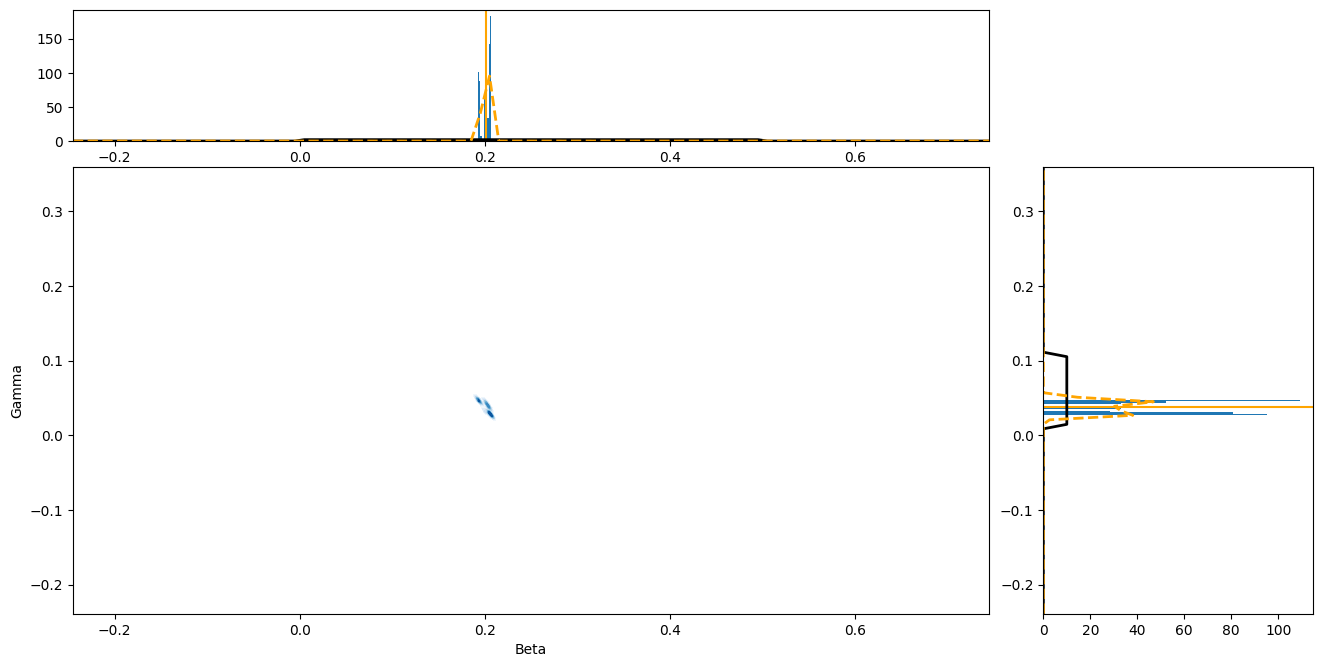

In [48]:
fig=plot_parameter_posteriors(parameter_names=["Beta","Gamma"],accepted_parameters=[p[2:] for p in accepted_params_adapt_me],predicted_vals=fitted_model_adapt_me.params[2:],priors=sir_priors[2:],weights=weights_adapt_me)

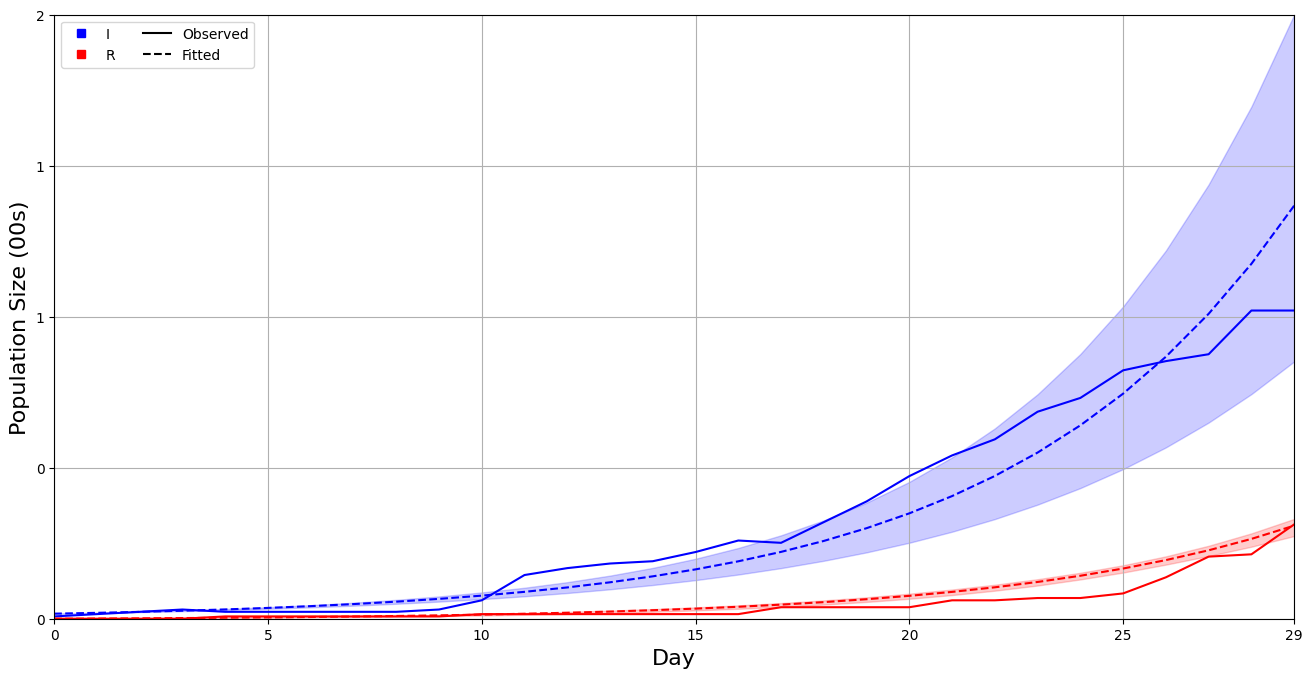

In [49]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.margins(0)

plot_ir_model_ci(ax,true_model.x_obs,true_model.observe(),fitted_model_adapt_me,accepted_params_adapt_me,weights=weights_adapt_me,alpha=0.1)
ax.set_title("",fontsize=20)

plt.grid()
plt.show()

# Two-Step ME

In [9]:
true_model=Models.SenegalRonaData()

In [10]:
theorised_model=Models.SIRModel(params=[1,1,1,1],n_obs=30,x_obs=[[i] for i in range(30)])
sir_priors=[stats.uniform(16743927,0),stats.uniform(2,0),stats.uniform(0,0.5),stats.uniform(.01,.1)]
sir_smc_priors=[stats.uniform(16743927,1),stats.uniform(2,0.5),stats.uniform(0,0.5),stats.uniform(.01,.1)]

In [11]:
# # SUMMARY STATISTICS
# scaled to be similiar to peak_infections_date
final_infectious_ss=(lambda ys:[np.log(ys[-1][1])])
final_removed_ss=(lambda ys:[np.log(ys[-1][2])])

net_weekly_infections_ss=(lambda ys:[np.log(abs(ys[i][1]-ys[i-7][1])) for i in range(7,len(ys)-1,7)]) # weekly change in infections (dim=3)
net_weekly_removed_ss=(lambda ys:[np.log(abs(ys[i][2]-ys[i-7][2])) for i in range(7,len(ys)-1,7)])

net_daily_infections_ss=(lambda ys:[np.log(max(abs(ys[i+1][1]-ys[i][1]),1)) for i in range(0,len(ys)-1)]) # daily change in infections (dim=29)
net_daily_removed_ss=(lambda ys:[np.log(max(abs(ys[i+1][2]-ys[i][2]),np.e)) for i in range(0,len(ys)-1)])

mean_infectious_ss=(lambda ys:[5*np.log(np.mean([y[1] for y in ys]))])
mean_removed_ss=(lambda ys:[9*np.log(np.mean([y[2] for y in ys]))])

cum_sum_infectious_ss=(lambda ys:np.cumsum([y[1] for y in ys]))
cum_sum_removed_ss=(lambda ys:np.cumsum([y[1] for y in ys]))

summary_stats=[final_infectious_ss,final_removed_ss, #0,1
               net_weekly_infections_ss,net_weekly_removed_ss, #2,3
               net_daily_infections_ss,net_daily_removed_ss, #4,5
               mean_infectious_ss,mean_removed_ss, #6,7
               cum_sum_infectious_ss,cum_sum_removed_ss] #8,9

In [15]:
%%time
returned_stats_me_2=[(0, 1), (0, 5), (0, 5), (0, 1, 7), (0, 6, 7), (2, 6, 7), (0, 5, 6), (3, 7, 8), (5, 7, 8), (0, 6, 7), (2, 6, 7), (2, 6, 7), (2, 6, 7), (0, 6, 7), (0, 1, 3), (0, 6, 7), (3, 5, 9), (0, 1), (0, 6, 7), (1, 2, 6), (6, 7), (3, 7, 8), (0, 5, 6), (2, 6, 7), (0, 1), (5, 6), (2, 6, 7)]
n_tests=20

for i in range(n_tests):
    print("{}/{} ".format(i,n_tests),end="")
    print(returned_stats_me_2,end="\n")
    
    best_stats,_=ABC.two_step_minimum_entropy(summary_stats=summary_stats,n_obs=30,y_obs=true_model.observe(),fitting_model=theorised_model,
                                              priors=sir_priors,min_subset_size=2,max_subset_size=3,n_samples=10000,n_accept=100,n_keep=100,printing=False)
    returned_stats_me_2.append(best_stats)
    
print("\n\nResults")
print_results(returned_stats_me_2,len(summary_stats))

0/20 [(0, 1), (0, 5), (0, 5), (0, 1, 7), (0, 6, 7), (2, 6, 7), (0, 5, 6), (3, 7, 8), (5, 7, 8), (0, 6, 7), (2, 6, 7), (2, 6, 7), (2, 6, 7), (0, 6, 7), (0, 1, 3), (0, 6, 7), (3, 5, 9), (0, 1), (0, 6, 7), (1, 2, 6), (6, 7), (3, 7, 8), (0, 5, 6), (2, 6, 7), (0, 1), (5, 6)]
1/20 [(0, 1), (0, 5), (0, 5), (0, 1, 7), (0, 6, 7), (2, 6, 7), (0, 5, 6), (3, 7, 8), (5, 7, 8), (0, 6, 7), (2, 6, 7), (2, 6, 7), (2, 6, 7), (0, 6, 7), (0, 1, 3), (0, 6, 7), (3, 5, 9), (0, 1), (0, 6, 7), (1, 2, 6), (6, 7), (3, 7, 8), (0, 5, 6), (2, 6, 7), (0, 1), (5, 6), (2, 6, 7)]


KeyboardInterrupt: 

In [19]:
print("Results")
print_results(returned_stats_me_2,len(summary_stats))

Results
([0,1],11.11%)
([0,5],7.41%)
([0,1,7],3.70%)
([0,6,7],18.52%)
([2,6,7],22.22%)
([0,5,6],7.41%)
([3,7,8],7.41%)
([5,7,8],3.70%)
([0,1,3],3.70%)
([3,5,9],3.70%)
([1,2,6],3.70%)
([6,7],3.70%)
([5,6],3.70%)
(ss_0,51.85%)
(ss_1,22.22%)
(ss_2,25.93%)
(ss_3,14.81%)
(ss_4,0.00%)
(ss_5,25.93%)
(ss_6,59.26%)
(ss_7,59.26%)
(ss_8,11.11%)
(ss_9,3.70%)


In [20]:
best_me2_ss=[2,6,7]
me2_ss=[summary_stats[i] for i in best_me2_ss]

In [23]:
%%time
# ABC-Rejection Sampling (Best Samples)
np.random.seed(16111998) # Fix random seed

sampling_details={"sampling_method":"best","num_runs":500000,"sample_size":500,"distance_measure":ABC.l2_norm}

fitted_model_me2,accepted_params_me2=ABC.abc_rejcection(n_obs=30,y_obs=true_model.observe(),fitting_model=theorised_model,priors=sir_priors,sampling_details=sampling_details,summary_stats=me2_ss,show_plots=False)
print("Fitted Model - {}\n".format(fitted_model_mee))

# 90% CI for R0 value
r0_estimate_rej=estimate_r0(accepted_params_me2)
print("R0 - [{:.3f},{:.3f}]".format(r0_estimate_rej[0],r0_estimate_rej[1]))
print("RSSE: {:,.3f}".format(ABC.two_d_rsse(fitted_model_mee.observe(),true_model.observe(),ln=True)))

# 95% CI
beta_ci=ci_parameters([p[2] for p in accepted_params_me2],alpha=.05,weights=None)
gamma_ci=ci_parameters([p[3] for p in accepted_params_me2],alpha=.05,weights=None)
print("Beta - [{:.3f},{:.3f}]\nGamma - [{:.3f},{:.3f}]".format(beta_ci[0],beta_ci[1],gamma_ci[0],gamma_ci[1]))

Fitted Model - Population Size=16,743,927.0      
Initially Infected=2.0
Beta=0.198
Gamma=0.027
R_0=7.236

R0 - [6.449,8.165]
RSSE: 349.900
Beta - [0.193,0.202]
Gamma - [0.024,0.031]
Wall time: 4min 48s


c:\users\dom\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


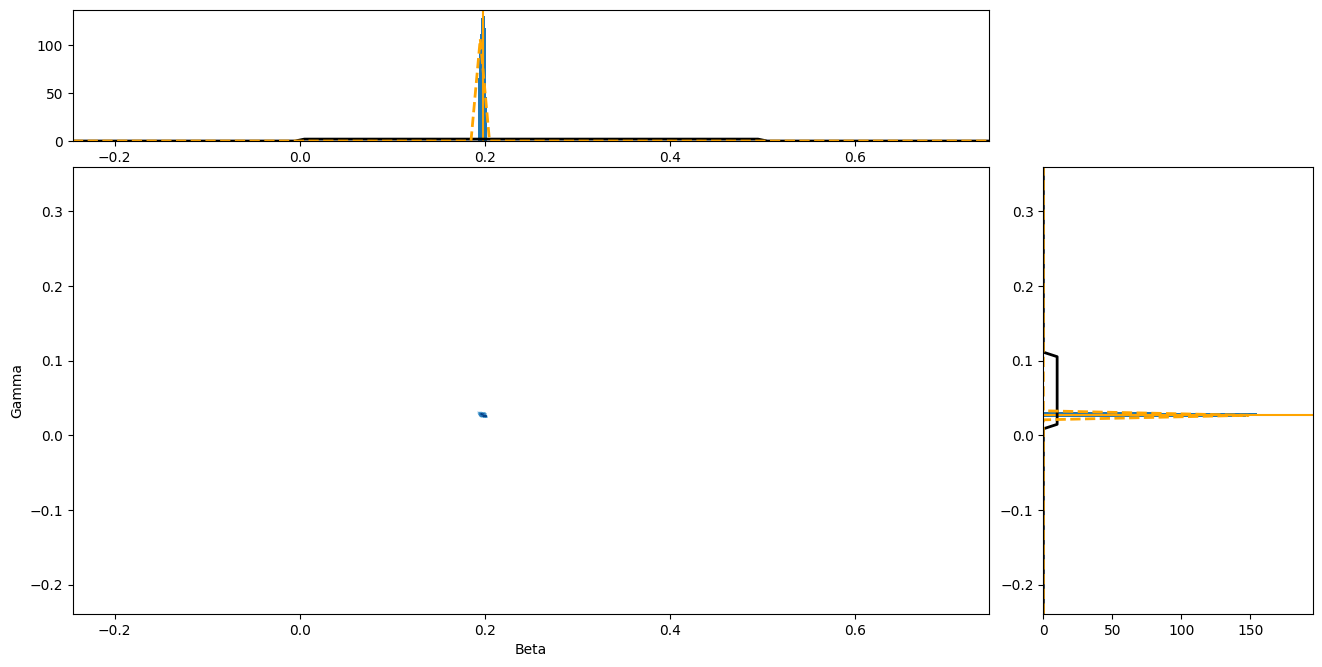

In [24]:
fig=plot_parameter_posteriors(parameter_names=["Beta","Gamma"],accepted_parameters=[p[2:] for p in accepted_params_me2],predicted_vals=fitted_model_me2.params[2:],priors=sir_priors[2:],weights=None)

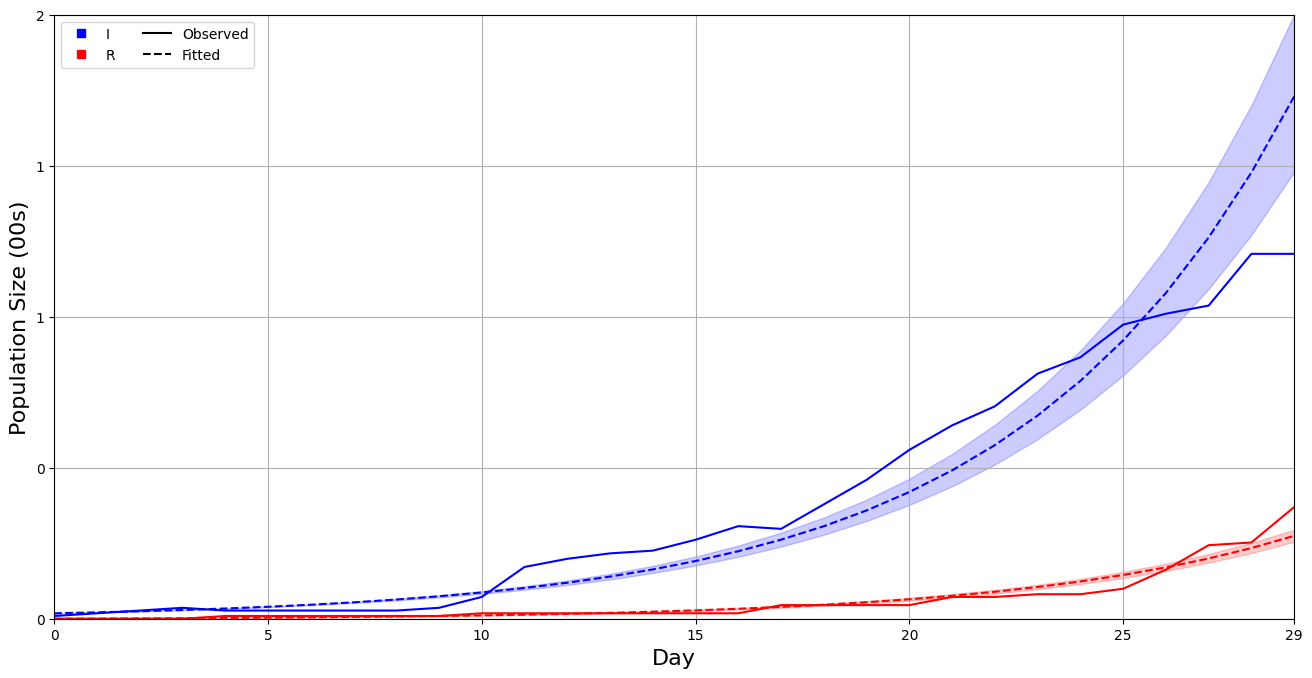

In [25]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.margins(0)

plot_ir_model_ci(ax,true_model.x_obs,true_model.observe(),fitted_model_me2,accepted_params_me2,weights=None,alpha=0.1)
ax.set_title("",fontsize=20)

plt.grid()
plt.show()

In [26]:
%%time
# Adaptive ABC-SMC
np.random.seed(16111998) # Fix random seed

fitted_model_adapt_me2,accepted_params_adapt_me2,weights_adapt_me2=ABC.adaptive_abc_smc(n_obs=30,y_obs=true_model.observe(),fitting_model=theorised_model,priors=sir_smc_priors,
    max_steps=100,sample_size=100,max_simulations=5000,summary_stats=me2_ss,
    acceptance_kernel=ABC.uniform_kernel,alpha=.9,distance_measure=ABC.l2_norm,show_plots=False)

print("Fitted Model - {}\n".format(fitted_model_adapt_me2))

# 90% CI for R0 value
r0_estimate_adapt_smc=estimate_r0(accepted_params_adapt_me2,weights=weights_adapt_me2)
print("R0 - [{:.3f},{:.3f}]".format(r0_estimate_adapt_smc[0],r0_estimate_adapt_smc[1]))
print("RSSE: {:,.3f}".format(ABC.two_d_rsse(fitted_model_adapt_me2.observe(),true_model.observe(),ln=True)))

# 95% CI
beta_ci=ci_parameters([p[2] for p in accepted_params_adapt_me2],alpha=.05,weights=weights_adapt_me2)
gamma_ci=ci_parameters([p[3] for p in accepted_params_adapt_me2],alpha=.05,weights=weights_adapt_me2)
print("Beta - [{:.3f},{:.3f}]\nGamma - [{:.3f},{:.3f}]".format(beta_ci[0],beta_ci[1],gamma_ci[0],gamma_ci[1]))

(100) - 100/100
Total Sims = 100 < 5,000

Perturbance Variances=[0.06984171 0.02053917 0.01797321 0.00090909]                       
(0/100 - 114) - 99/100 (eps=61.835>0.000)
Total Sims = 214 < 5,000

Perturbance Variances=[0.06662022 0.0201507  0.01182313 0.00084393]                       
(1/100 - 105) - 99/100 (eps=51.667>0.000)
Total Sims = 319 < 5,000

Perturbance Variances=[0.06213832 0.01721477 0.00789524 0.00079981]                       
(2/100 - 115) - 99/100 (eps=37.473>0.000)
Total Sims = 434 < 5,000

Perturbance Variances=[0.06615442 0.01535901 0.00707133 0.00066704]                       
(3/100 - 111) - 99/100 (eps=35.226>0.000)
Total Sims = 545 < 5,000

Perturbance Variances=[0.04692225 0.01279855 0.00558535 0.00072906]                       
(4/100 - 111) - 99/100 (eps=25.934>0.000)
Total Sims = 656 < 5,000

Perturbance Variances=[0.04611215 0.01308648 0.00409902 0.00069638]                       
(5/100 - 115) - 99/100 (eps=24.499>0.000)
Total Sims = 771 < 5,000

Pert

NameError: name 'accepted_params_adapt_me' is not defined

In [29]:
# 95% CI
beta_ci=ci_parameters([p[2] for p in accepted_params_adapt_me2],alpha=.05,weights=weights_adapt_me2)
gamma_ci=ci_parameters([p[3] for p in accepted_params_adapt_me2],alpha=.05,weights=weights_adapt_me2)
print("Beta - [{:.3f},{:.3f}]\nGamma - [{:.3f},{:.3f}]".format(beta_ci[0],beta_ci[1],gamma_ci[0],gamma_ci[1]))

Beta - [0.203,0.240]
Gamma - [0.011,0.066]


c:\users\dom\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


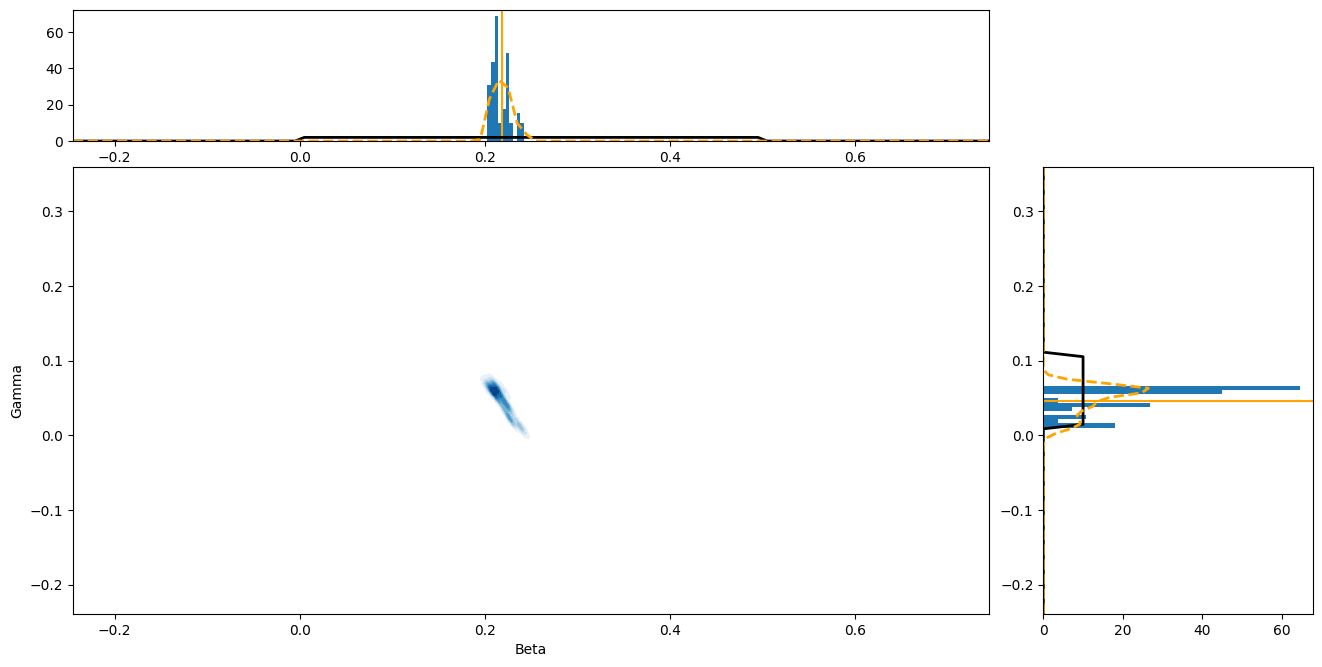

In [27]:
fig=plot_parameter_posteriors(parameter_names=["Beta","Gamma"],accepted_parameters=[p[2:] for p in accepted_params_adapt_me2],predicted_vals=fitted_model_adapt_me2.params[2:],priors=sir_priors[2:],weights=weights_adapt_me2)

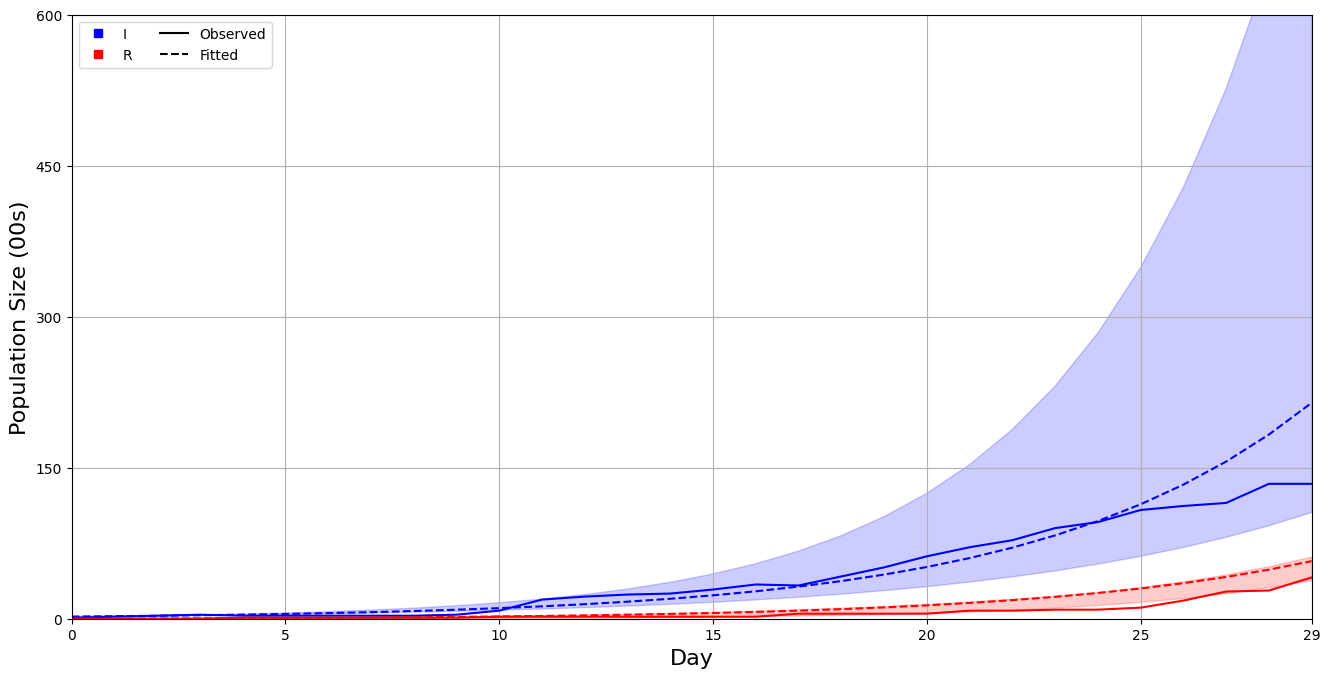

In [34]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.margins(0)

plot_ir_model_ci(ax,true_model.x_obs,true_model.observe(),fitted_model_adapt_me2,accepted_params_adapt_me2,weights=weights_adapt_me2,alpha=0.1)
ax.set_title("",fontsize=20)

plt.grid()
plt.show()